# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it

import matplotlib.pyplot as plt
from IPython.core.display    import HTML

import warnings
warnings.filterwarnings( 'ignore' )

from sklearn.preprocessing   import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from lightgbm                import LGBMClassifier
from sklearn.metrics         import accuracy_score, precision_score, recall_score
from sklearn.metrics         import roc_auc_score, f1_score, roc_curve

import xgboost               as xgb
import scikitplot.metrics    as mtr


# Import Data

In [2]:
df_raw = pd.read_csv('hotel_bookings.csv')

# Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display (HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

jupyter_settings()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 20)
        plot.tick_params(axis='x', labelsize=15)
    plt.show()
    
def with_hue(plot, feature, number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(number_of_categories):
        total = a[i] + a[i+number_of_categories]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*number_of_categories + i)]/total)
            x = patch[(j*number_of_categories + i)].get_x() + patch[(j*number_of_categories + i)].get_width() / 2
            y = patch[(j*number_of_categories + i)].get_y() + patch[(j*number_of_categories + i)].get_height() 
            plot.annotate(percentage, (x, y), size = 20)
            plot.tick_params(axis='x', labelsize=15)
    plt.show()

order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

color = 'cornflowerblue'

def metrics_score(model_name, df):
    acc = accuracy_score(df[3], df[2])
    pre = precision_score(df[3], df[2])
    rec = recall_score(df[3], df[2])
    ras = roc_auc_score(df[3], df[1])
    f1s = f1_score(df[3], df[2])
    
    return pd.DataFrame([[model_name, acc, pre, rec, ras, f1s]],
                        columns = ['Model', 'accuracy', 'precision', 'recall', 'roc_auc_score', 'f1_score'])

def cross_validation(model_name, kfold, mcv):
    for i in range(len(model_name)):
        scores = cross_validate(model_name[i][0], X_train, y_train, cv = kfold, scoring=scoring)
        
        model = pd.DataFrame([[model_name[i][1], scores['test_accuracy'].mean(), scores['test_precision'].mean(), scores['test_recall'].mean(),
                        scores['test_roc_auc'].mean(), scores['test_f1'].mean()]],
                        columns = ['Model', 'accuracy', 'precision', 'recall', 'roc_auc_score', 'f1_score'])
        if i == 0:
            models_cv = model
        else:
            models_cv = models_cv.append(model, ignore_index=True)
        
    return models_cv

Populating the interactive namespace from numpy and matplotlib


# Feature Description

1: hotel

Hotel (H1 = Resort Hotel or H2 = City Hotel)


2: is_canceled

Value indicating if the booking was canceled (1) or not (0)


3: lead_time

Number of days that elapsed between the entering date of the booking into the PMS and the arrival date


4: arrival_date_year

Year of arrival date


5: arrival_date_month

Month of arrival date


6: arrival_date_week_number

Week number of year for arrival date


7: arrival_date_day_of_month

Day of arrival date


8: stays_in_weekend_nights

Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel


9: stays_in_week_nights

Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel


10: adults

Number of adults


11: children

Number of children


12: babies

Number of babies


13: meal

Type of meal booked. Categories are presented in standard hospitality meal packeges: Undefined/SC - no meal package; BB - Bed& Breakfast; HB - Half board (breakfast and one other meal - usually dinner); FB - Full board (breakfast, lunch and dinner)


14: country

Country of origin. Categories are represented in the ISO 3155-3:2013 format


15: market_segment

Market segment designation. In categories, the term "TA" means "Travel Agents" and "TO" means "Tour Operators" 


16: distribution_channel

Booking distribution channel. The term "TA" means "Travel Agents" and "TO" means "Tour Operators".


17: is_repeated_guest

Value indicating if the booking name was from a repeated guest (1) or not (0)


18: previous_cancellations

Number of previous bookings that were cancelled by the customer prior to the current booking


19: previous_bookings_not_canceled

Number of previous bookings not cancelled by the customer prior to the current booking


20: reserved_room_type

Code of room type reserved. Code is presented instead of designation for anonymity reasons


21: assigned_room_type

Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.


22: booking_changes

Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation


23: deposit_type

Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit - no deposit was made; Non Refund - a deposit was made in the value of the total stay cost; Refundable - a deposit was made with a value under the total cost of stay


24: agent

ID of the travel agency that made the booking


25: company

ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for designation for anonymity reasons


26: days_in_waiting_list

Number of days the booking was in the waiting list before it was confirmed to the customer


27: customer_type

Type of booking assuming one of four categorires: Contract - when the booking has an allotment or other type of contract associated to it; Group - when the booking is associated to a group; Transient - when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-Party - when the booking is transient, but is associated to at least other transient booking


28: adr

Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights


29: required_car_parking_spaces

Number of car parking spaces required by the customer


30: total_of_special_requests

Numer of special requests made by the customer (e.g. twin bed or high floor)

31: reservation_status

Reservation last status, assuming one of three categories: Canceled - booking was canceled by the customer; Check-Out - customer has checked in but already departed; No-Show - customer did not check-in and did inform the hotel of the reason why


32: reservation_status_date

Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checek-out of the hotel

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 1.1 Data Dimensions

In [6]:
print('number of rows {}'.format(df1.shape[0]))
print('number of cols {}'.format(df1.shape[1]))

number of rows 119390
number of cols 32


## 1.2 Check Na

In [7]:
df1.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

## 1.3 Fill Na

### 1.3.1 Children

In [8]:
df1['children'].value_counts(normalize=True)

0.0     0.928049
1.0     0.040717
2.0     0.030590
3.0     0.000637
10.0    0.000008
Name: children, dtype: float64

In [9]:
df1['children'].fillna(0, inplace=True)

### 1.3.2 Country

In [10]:
df1['country'].fillna('UNK', inplace = True)

### 1.3.3 Agent

In [11]:
df1['agent'].fillna(0, inplace=True)

### 1.3.4 Company

In [12]:
df1['company'].fillna(0, inplace=True)

In [13]:
df1.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## 1.4 Data Types

In [14]:
df1.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [15]:
df1.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 1.5 Change Data Types

In [16]:
# children
df1['children'] = df1['children'].astype(int64)

# agent
df1['agent'] = df1['agent'].astype(int64)

# company
df1['company'] = df1['company'].astype(int64)

In [17]:
df1.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

## 1.6 Descriptive Statistics

### 1.6.1 Numeric Attributes

In [18]:
df1_num = df1[['lead_time', 'days_in_waiting_list']]

ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

d1 = pd.DataFrame(df1_num.apply(np.std)).T
d2 = pd.DataFrame(df1_num.apply(min)).T
d3 = pd.DataFrame(df1_num.apply(max)).T
d4 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

ds = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ds.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ds

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,lead_time,0.0,737.0,737.0,104.011416,69.0,106.862650,1.346550,1.696449
1,days_in_waiting_list,0.0,391.0,391.0,2.321149,0.0,17.594647,11.944353,186.793070


### 1.6.2 Categorical Attributes

In [19]:
# Hotel
df1['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

In [20]:
# arrival_date_year
df1['arrival_date_year'].value_counts().sort_index()

2015    21996
2016    56707
2017    40687
Name: arrival_date_year, dtype: int64

In [21]:
# arrival_date_month
dfa = pd.DataFrame(df1['arrival_date_month'].value_counts().sort_index())
dfa.index = pd.CategoricalIndex(dfa.index, categories=order, ordered=True)
dfa.sort_index().squeeze()

January       5929
February      8068
March         9794
April        11089
May          11791
June         10939
July         12661
August       13877
September    10508
October      11160
November      6794
December      6780
Name: arrival_date_month, dtype: int64

In [22]:
# arrival_date_week_number
df1['arrival_date_week_number'].value_counts().sort_index()

1     1047
2     1218
3     1319
4     1487
5     1387
6     1508
7     2109
8     2216
9     2117
10    2149
11    2070
12    2083
13    2416
14    2264
15    2689
16    2405
17    2805
18    2926
19    2402
20    2785
21    2854
22    2546
23    2621
24    2498
25    2663
26    2391
27    2664
28    2853
29    2763
30    3087
31    2741
32    3045
33    3580
34    3040
35    2593
36    2167
37    2229
38    2661
39    2581
40    2397
41    2699
42    2756
43    2352
44    2272
45    1941
46    1574
47    1685
48    1504
49    1782
50    1505
51     933
52    1195
53    1816
Name: arrival_date_week_number, dtype: int64

In [23]:
# arrival_date_day_of_month
df1['arrival_date_day_of_month'].value_counts().sort_index()

1     3626
2     4055
3     3855
4     3763
5     4317
6     3833
7     3665
8     3921
9     4096
10    3575
11    3599
12    4087
13    3745
14    3819
15    4196
16    4078
17    4406
18    4002
19    4052
20    4032
21    3767
22    3596
23    3616
24    3993
25    4160
26    4147
27    3802
28    3946
29    3580
30    3853
31    2208
Name: arrival_date_day_of_month, dtype: int64

In [24]:
# stays_in_weekend_nights
df1['stays_in_weekend_nights'].value_counts().sort_index()

0     51998
1     30626
2     33308
3      1259
4      1855
5        79
6       153
7        19
8        60
9        11
10        7
12        5
13        3
14        2
16        3
18        1
19        1
Name: stays_in_weekend_nights, dtype: int64

In [25]:
# stays_in_week_nights
df1['stays_in_week_nights'].value_counts().sort_index()

0      7645
1     30310
2     33684
3     22258
4      9563
5     11077
6      1499
7      1029
8       656
9       231
10     1036
11       56
12       42
13       27
14       35
15       85
16       16
17        4
18        6
19       44
20       41
21       15
22        7
24        3
25        6
26        1
30        5
32        1
33        1
34        1
35        1
40        2
41        1
42        1
50        1
Name: stays_in_week_nights, dtype: int64

In [26]:
# Adults
df1['adults'].value_counts().sort_index()

0       403
1     23027
2     89680
3      6202
4        62
5         2
6         1
10        1
20        2
26        5
27        2
40        1
50        1
55        1
Name: adults, dtype: int64

In [27]:
# Children
df1['children'].value_counts()

0     110800
1       4861
2       3652
3         76
10         1
Name: children, dtype: int64

In [28]:
# Babies
df1['babies'].value_counts()

0     118473
1        900
2         15
9          1
10         1
Name: babies, dtype: int64

In [29]:
# Meal
df1['meal'].value_counts()

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

In [30]:
# Country
df1['country'].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
ITA     3766
IRL     3375
BEL     2342
BRA     2224
NLD     2104
USA     2097
CHE     1730
CN      1279
AUT     1263
SWE     1024
CHN      999
POL      919
ISR      669
RUS      632
NOR      607
ROU      500
UNK      488
FIN      447
DNK      435
AUS      426
AGO      362
LUX      287
MAR      259
TUR      248
HUN      230
ARG      214
JPN      197
CZE      171
IND      152
KOR      133
GRC      128
DZA      103
SRB      101
HRV      100
MEX       85
IRN       83
EST       83
LTU       81
ZAF       80
BGR       75
NZL       74
COL       71
UKR       68
MOZ       67
SVK       65
CHL       65
THA       59
ISL       57
SVN       57
LVA       55
CYP       51
ARE       51
TWN       51
SAU       48
PHL       40
SGP       39
TUN       39
IDN       35
NGA       34
EGY       32
URY       32
LBN       31
HKG       29
PER       29
MYS       28
ECU       27
VEN       26
BLR       26
CPV       24
GEO       22
JOR       21
CRI       19

In [31]:
# market_segment
df1['market_segment'].value_counts()

Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64

In [32]:
# distribution_channel
df1['distribution_channel'].value_counts()

TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: distribution_channel, dtype: int64

In [33]:
# is_repeated_guest
df1['is_repeated_guest'].value_counts()

0    115580
1      3810
Name: is_repeated_guest, dtype: int64

In [34]:
# previous_cancelations
df1['previous_cancellations'].value_counts().sort_index()

0     112906
1       6051
2        116
3         65
4         31
5         19
6         22
11        35
13        12
14        14
19        19
21         1
24        48
25        25
26        26
Name: previous_cancellations, dtype: int64

In [35]:
# previous_bookings_not_canceled
df1['previous_bookings_not_canceled'].value_counts().sort_index()

0     115770
1       1542
2        580
3        333
4        229
5        181
6        115
7         88
8         70
9         60
10        53
11        43
12        37
13        30
14        28
15        21
16        20
17        16
18        14
19        13
20        12
21        12
22        10
23         7
24         9
25        17
26         7
27         9
28         7
29         6
30         4
31         2
32         2
33         1
34         1
35         1
36         1
37         1
38         1
39         1
40         1
41         1
42         1
43         1
44         2
45         1
46         1
47         1
48         2
49         1
50         1
51         1
52         1
53         1
54         1
55         1
56         1
57         1
58         2
59         1
60         1
61         1
62         1
63         1
64         1
65         1
66         1
67         1
68         1
69         1
70         1
71         1
72         1
Name: previous_bookings_not_canceled, dtype: int64

In [36]:
# reserved_room_type
df1['reserved_room_type'].value_counts().sort_index()

A    85994
B     1118
C      932
D    19201
E     6535
F     2897
G     2094
H      601
L        6
P       12
Name: reserved_room_type, dtype: int64

In [37]:
# assigned_room_type
df1['assigned_room_type'].value_counts().sort_index()

A    74053
B     2163
C     2375
D    25322
E     7806
F     3751
G     2553
H      712
I      363
K      279
L        1
P       12
Name: assigned_room_type, dtype: int64

In [38]:
# booking_changes
df1['booking_changes'].value_counts().sort_index()

0     101314
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
11         2
12         2
13         5
14         5
15         3
16         2
17         2
18         1
20         1
21         1
Name: booking_changes, dtype: int64

In [39]:
# deposit_type
df1['deposit_type'].value_counts()

No Deposit    104641
Non Refund     14587
Refundable       162
Name: deposit_type, dtype: int64

In [40]:
# Agent
df1['agent'].value_counts()

9      31961
0      16340
240    13922
1       7191
14      3640
7       3539
6       3290
250     2870
241     1721
28      1666
8       1514
3       1336
37      1230
19      1061
40      1039
314      927
21       875
229      786
242      780
83       696
29       683
171      607
12       578
85       554
20       540
96       537
243      514
30       484
134      482
298      472
27       450
15       402
26       401
11       395
22       382
56       375
273      349
177      347
86       338
58       335
5        330
119      304
196      301
34       294
44       292
138      287
315      284
38       274
10       260
236      247
16       246
17       241
115      225
251      220
68       211
42       211
191      198
175      195
154      193
195      193
156      190
168      184
152      183
208      173
143      172
326      165
2        162
31       162
147      156
132      143
142      137
52       137
95       135
410      133
248      131
234      128
39       127

In [41]:
# Company
df1['company'].value_counts()

0      112593
40        927
223       784
67        267
45        250
153       215
174       149
219       141
281       138
154       133
405       119
233       114
51         99
94         87
47         72
135        66
169        65
242        62
331        61
348        59
498        58
110        52
38         51
20         50
342        48
280        48
91         48
197        47
62         47
68         46
218        43
270        43
195        38
202        38
148        37
9          37
307        36
113        36
204        34
269        33
238        33
308        33
86         32
72         30
385        30
343        29
43         29
365        29
221        27
178        27
144        27
46         26
337        25
418        25
424        24
366        24
179        24
227        24
507        23
477        23
81         23
407        22
88         22
78         22
216        21
286        21
209        19
523        19
150        19
396        18
292        18
122   

In [42]:
# customer_type
df1['customer_type'].value_counts()

Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: customer_type, dtype: int64

In [43]:
# required_car_parking_spaces
df1['required_car_parking_spaces'].value_counts()

0    111974
1      7383
2        28
3         3
8         2
Name: required_car_parking_spaces, dtype: int64

In [44]:
# total_of_special_requests
df1['total_of_special_requests'].value_counts()

0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: total_of_special_requests, dtype: int64

In [45]:
# reservation_status
df1['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

In [46]:
df1['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

# 2.0 Feature Engineering

In [47]:
df2 = df1.copy()

In [48]:
df2['assigned_reserved'] = df2.apply(lambda x: 1 if x['reserved_room_type'] == x['assigned_room_type'] else 0, axis=1)

## 2.1 Hypotesis Creation

**H01** - There is a higher percentage of canceled reservations at City Hotels than at Resort Hotels

**H02** - The longer the lead time, days that elapse between the booking date and the arrival date, the more likely the reservation is to be canceled

**H03** - The percentage of canceled reservations increases in the months with the highest number of reservations

**H04** - Reservations made by families with babies are more likely to be canceled

**H05** - Reservations made by the market segment group are less likely to be canceled

**H06** - Reservations made by customers who have already used the services are less likely to be canceled

**H07** - Customers who have previously canceled reservations are more likely to cancel again

**H08** - The greater the number of previous uncanceled reservations made by a customer, the less likely their future reservations are to be canceled.

**H09** - The percentage of canceled reservations is higher when the room type assigned is different from the room type reserved

**H10** - Customers who do not make changes or amendments to their booking are less likely to cancel their reservations

**H11** - The probability of canceled reservations is lower after the deposit was made

**H12** - Reservations made by companies or entities have a lower percentage of being canceled

**H13** - The greater the number of days on the waiting list, the more likely the reservation is to be canceled

**H14** - The greater the number of special requests, the more likely the reservation is to be canceled

# 3.0 Data Filtering

In [49]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [50]:
df4 = df3.copy()

## 4.1 Response Variable

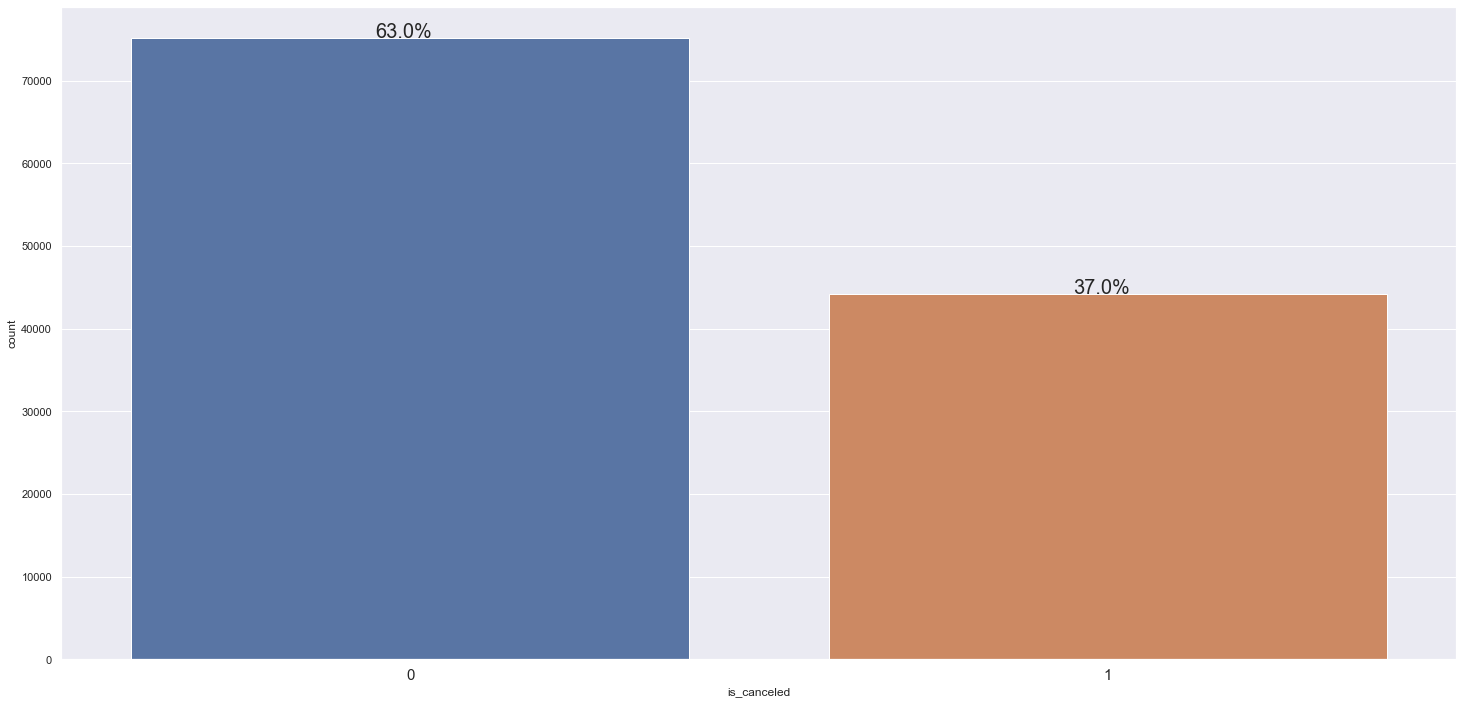

In [51]:
graphic = sns.countplot(df4['is_canceled'])
without_hue(graphic, df4['is_canceled'])

## 4.2 Univariate Analysis

<AxesSubplot:xlabel='arrival_date_day_of_month', ylabel='Count'>

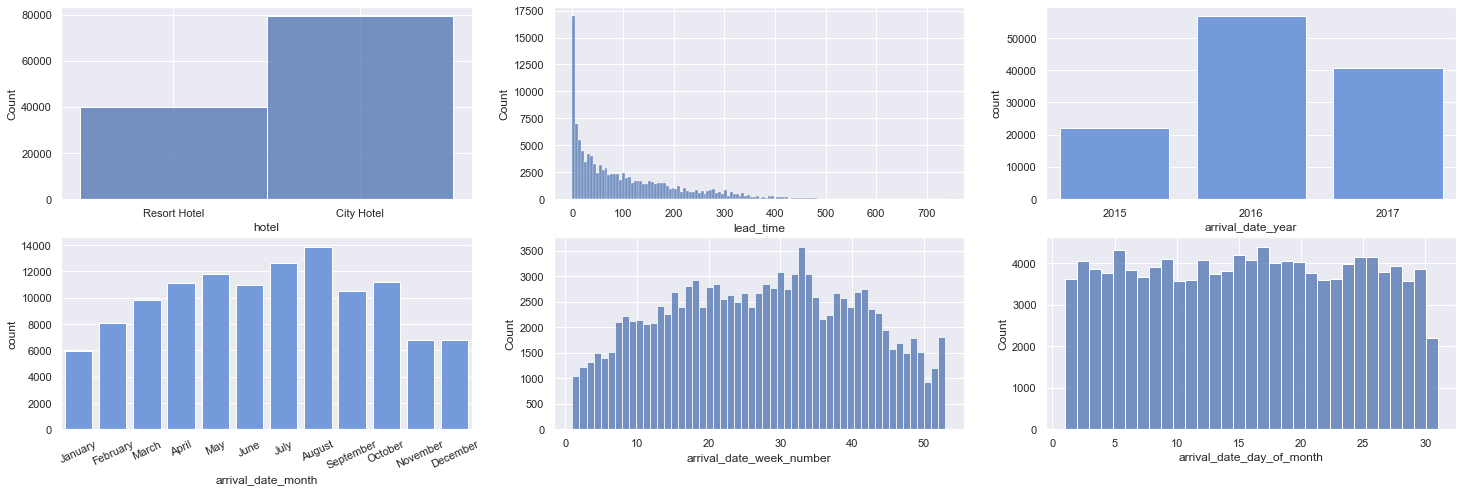

In [52]:
plt.subplot(3, 3, 1)
sns.histplot(df4['hotel'])

plt.subplot(3, 3, 2)
sns.histplot(df4['lead_time'])

plt.subplot(3, 3, 3)
sns.countplot(df4['arrival_date_year'], color=color);

plt.subplot(3, 3, 4)
plt.xticks(rotation=25)
sns.countplot(df4['arrival_date_month'], order=order, color=color)

plt.subplot(3, 3, 5)
sns.histplot(df4['arrival_date_week_number'], bins=53);

plt.subplot(3, 3, 6)
sns.histplot(df4['arrival_date_day_of_month'], bins=31)

<AxesSubplot:xlabel='meal', ylabel='count'>

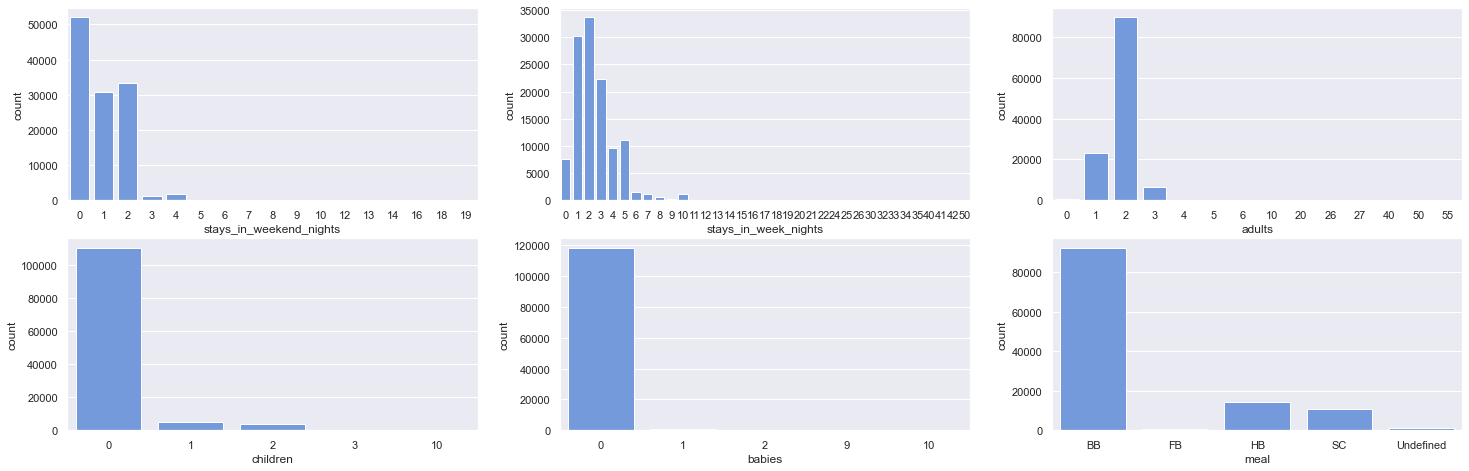

In [53]:
plt.subplot(3, 3, 1)
sns.countplot(df4['stays_in_weekend_nights'], color=color)

plt.subplot(3, 3, 2)
sns.countplot(df4['stays_in_week_nights'], color=color)

plt.subplot(3, 3, 3)
sns.countplot(df4['adults'], color=color)

plt.subplot(3, 3, 4)
sns.countplot(df4['children'], color=color)

plt.subplot(3, 3, 5)
sns.countplot(df4['babies'], color=color)

plt.subplot(3, 3, 6)
sns.countplot(df4['meal'], color=color)

<AxesSubplot:xlabel='booking_changes', ylabel='count'>

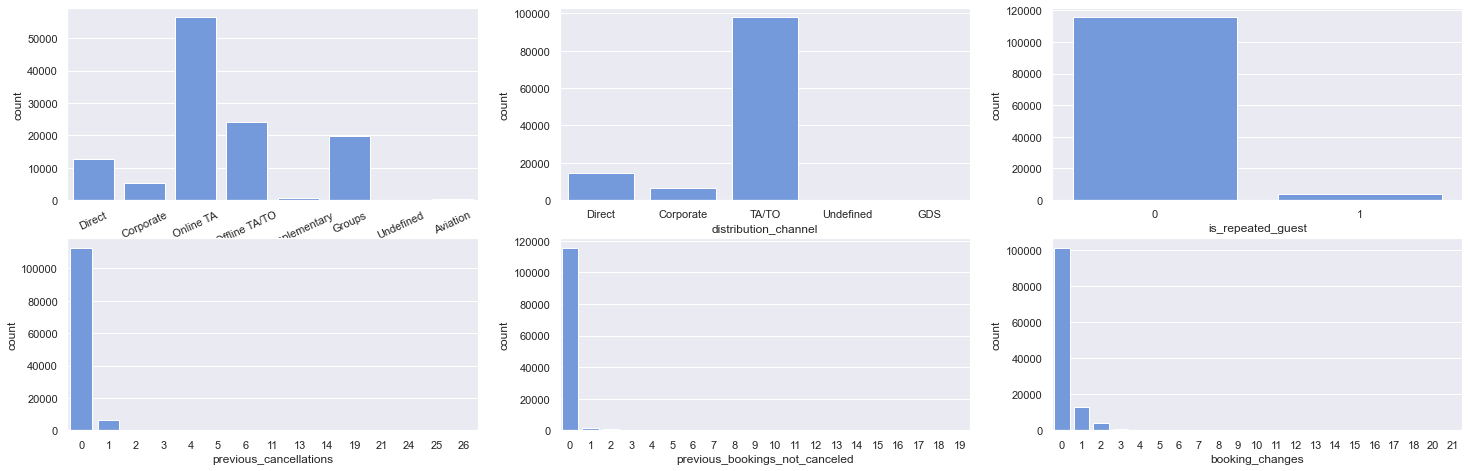

In [54]:
plt.subplot(3, 3, 1)
plt.xticks(rotation=25)
sns.countplot(df4['market_segment'], color=color)

plt.subplot(3, 3, 2)
sns.countplot(df4['distribution_channel'], color=color)

plt.subplot(3, 3, 3)
sns.countplot(df4['is_repeated_guest'], color=color)

plt.subplot(3, 3, 4)
sns.countplot(df4['previous_cancellations'], color = color)

plt.subplot(3, 3, 5)
df_aux=df4[df4['previous_bookings_not_canceled']<20]
sns.countplot(df_aux['previous_bookings_not_canceled'], color=color)

plt.subplot(3, 3, 6)
sns.countplot(df4['booking_changes'], color=color)

<AxesSubplot:xlabel='company', ylabel='count'>

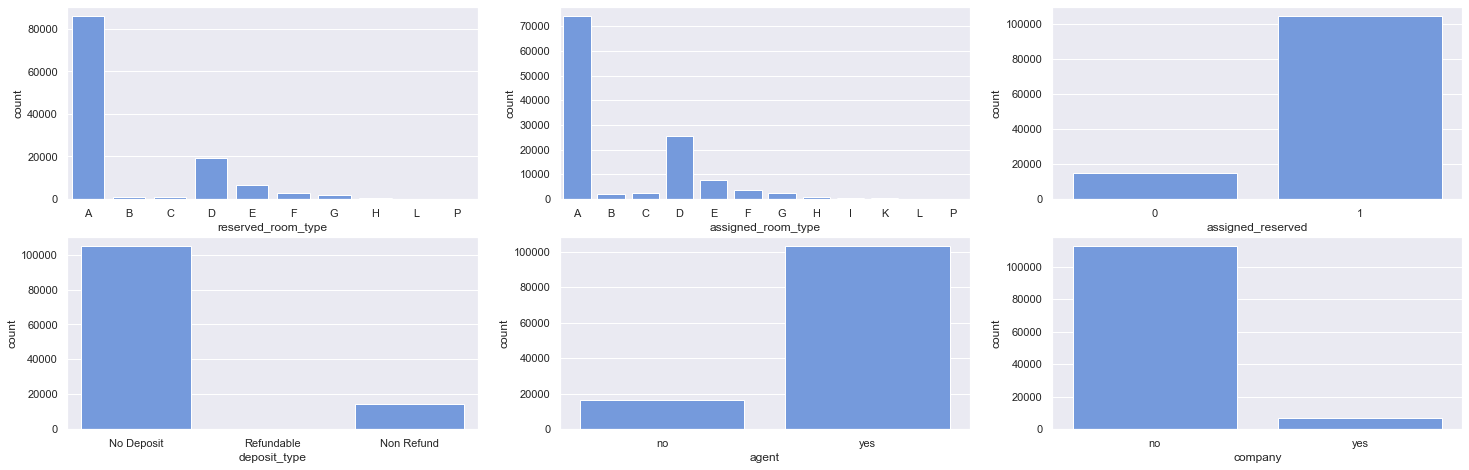

In [55]:
plt.subplot(3, 3, 1)
sns.countplot(df4['reserved_room_type'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L', 'P'], color=color)

plt.subplot(3, 3, 2)
sns.countplot(df4['assigned_room_type'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'P'], color=color)

plt.subplot(3, 3, 3)
sns.countplot(df4['assigned_reserved'], color=color)

plt.subplot(3, 3, 4)
sns.countplot(df4['deposit_type'], color=color)

plt.subplot(3, 3, 5)
df_aux = df4.copy()
df_aux['agent'] = df_aux['agent'].apply(lambda x: 'no' if x == 0 else 'yes')
sns.countplot(df_aux['agent'], color=color)

plt.subplot(3, 3, 6)
df_aux = df4.copy()
df_aux['company'] = df_aux['company'].apply(lambda x: 'no' if x == 0 else 'yes')
sns.countplot(df_aux['company'], color=color)

<AxesSubplot:xlabel='reservation_status', ylabel='count'>

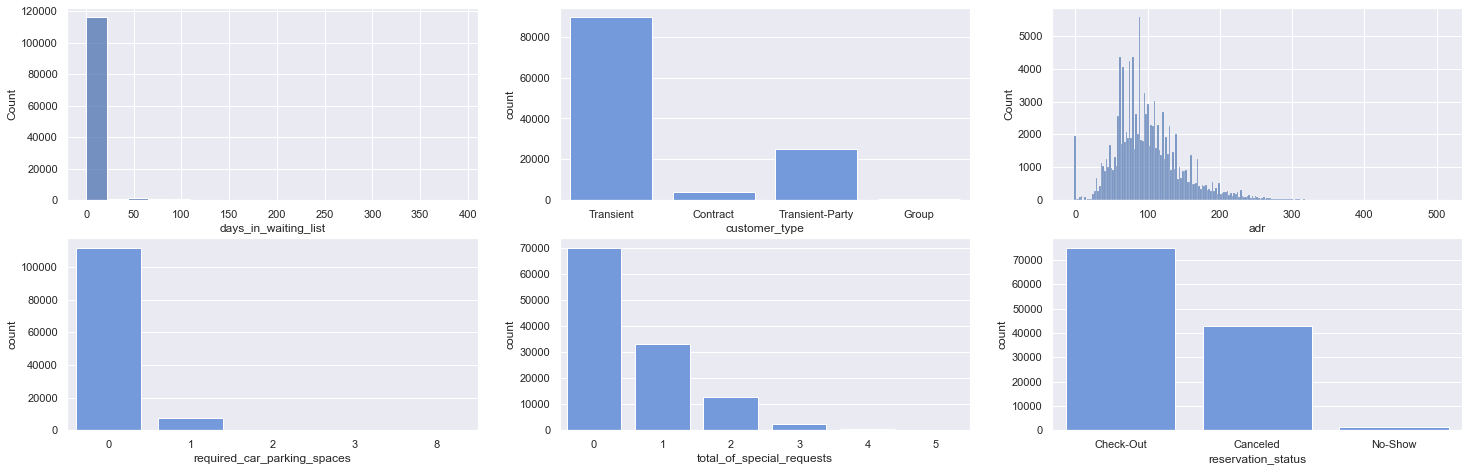

In [56]:
plt.subplot(3, 3, 1)
sns.histplot(df4['days_in_waiting_list'])

plt.subplot(3, 3, 2)
sns.countplot(df4['customer_type'], color=color)

plt.subplot(3, 3, 3)
df_aux= df4[df4['adr']<1000]
sns.histplot(df_aux['adr'])

plt.subplot(3, 3, 4)
sns.countplot(df4['required_car_parking_spaces'], color=color)

plt.subplot(3, 3, 5)
sns.countplot(df4['total_of_special_requests'], color=color)

plt.subplot(3, 3, 6)
sns.countplot(df4['reservation_status'], color=color)

## 4.3 Bivariate Analysis

### **H01** - There is a higher percentage of canceled reservations at City Hotels than at Resort Hotels

*True*, 41.7% of reservations made at City Hotels were canceled and a lower percentage value 21.8% of reservations made at Resort Hotels were canceled.

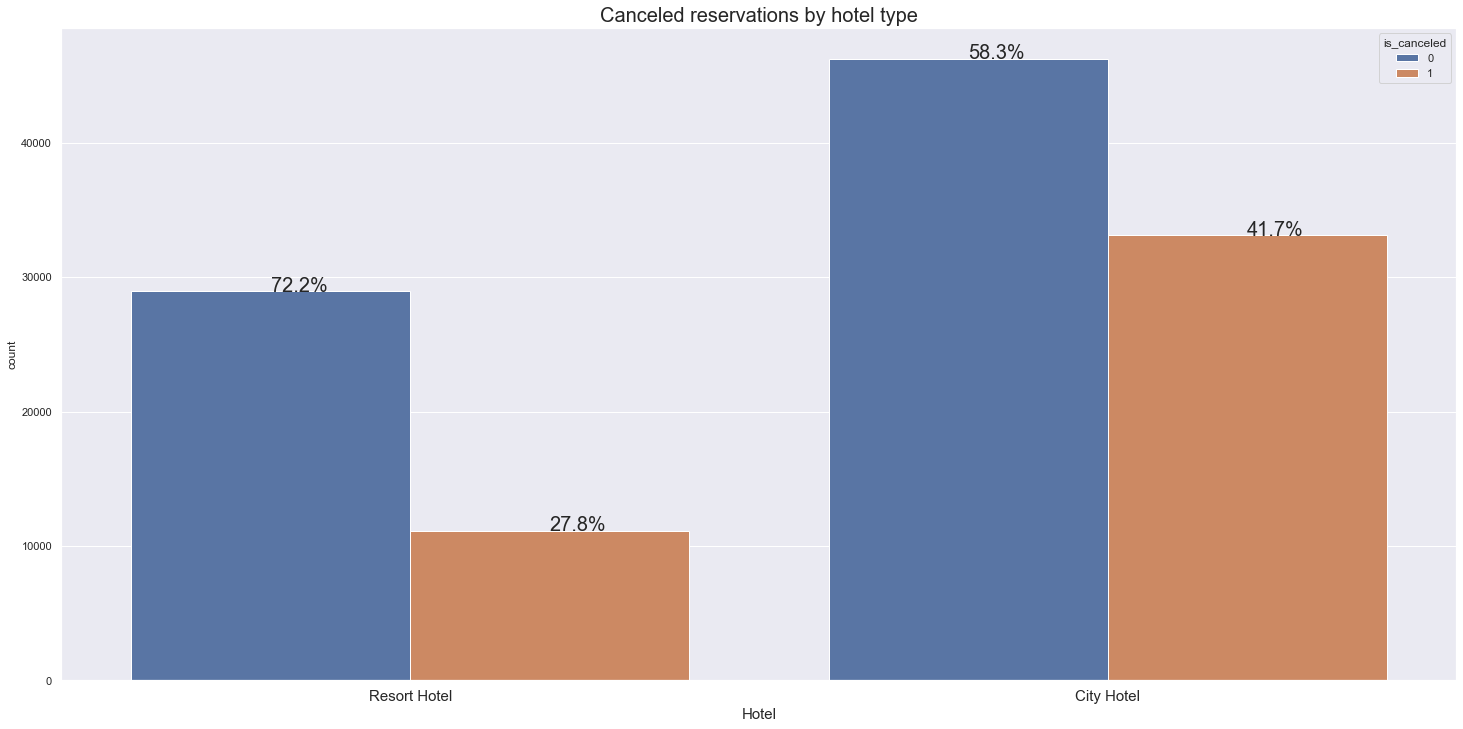

In [57]:
graphic = sns.countplot(x='hotel', data=df4, hue='is_canceled')
plt.title('Canceled reservations by hotel type', fontdict = {'fontsize':20})
plt.xlabel('Hotel', fontsize=15)
with_hue(graphic, df4['hotel'], 2, 2)

### **H02** - The longer the lead time, days that elapse between the booking date and the arrival date, the more likely the reservation is to be canceled

*True*, the percentage of canceled reservations increases as the lead time increases

In [58]:
df_aux = df4.copy()
df_aux['lead_time'] = df_aux['lead_time'].apply(lambda x: 'less than 100 days' if x <= 100
                                               else 'between 100 and 200 days' if (x>100)&(x<=200)
                                               else 'between 200 and 300 days' if (x>200)&(x<=300)
                                               else 'between 300 and 400 days' if (x>300)&(x<=400)
                                               else 'more than 500 days')

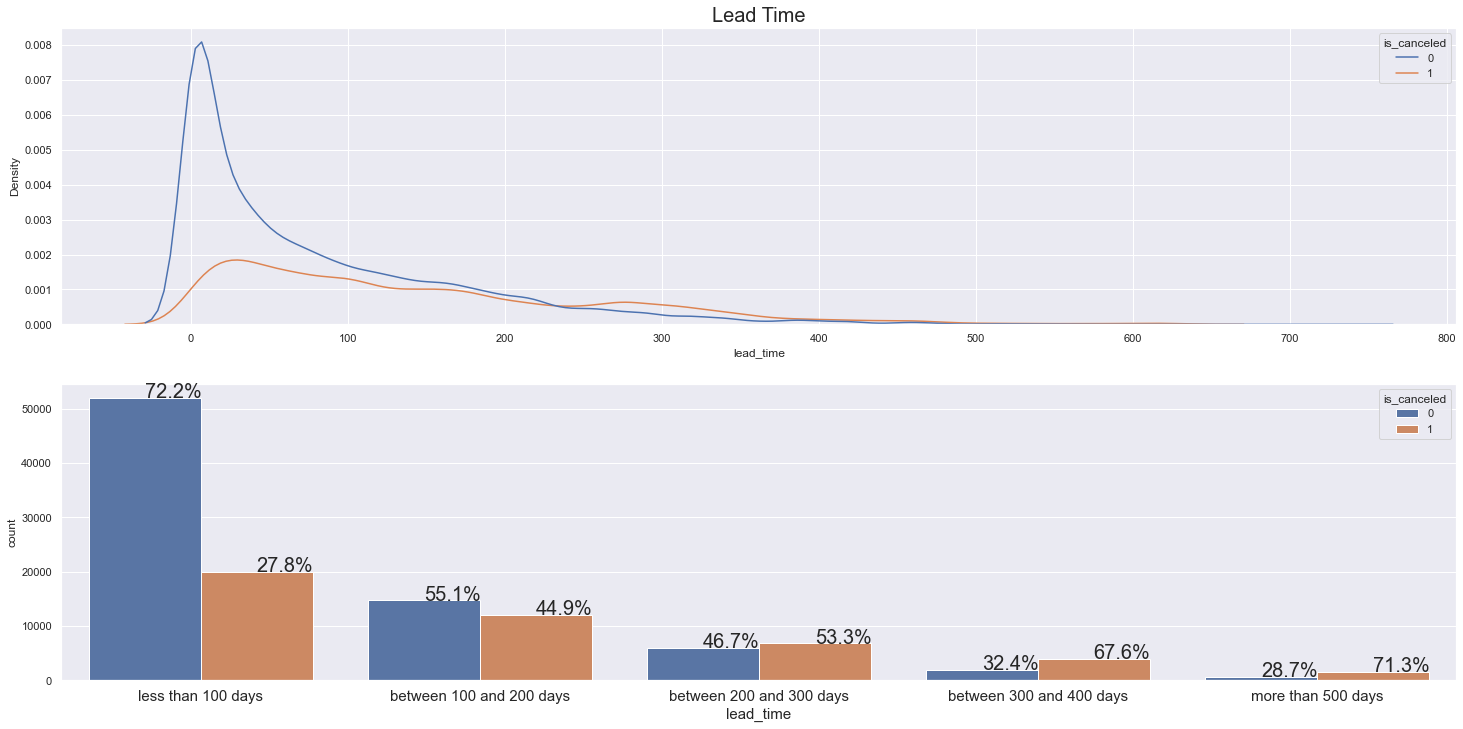

In [59]:
plt.subplot(2, 1, 1)
sns.kdeplot(data = df4, x='lead_time', hue='is_canceled', common_norm=True)
plt.title('Lead Time', fontdict = {'fontsize':20})

plt.subplot(2, 1, 2)
graphic = sns.countplot(data = df_aux, x='lead_time', hue='is_canceled', order=('less than 100 days', 'between 100 and 200 days',
                                                                               'between 200 and 300 days', 'between 300 and 400 days',
                                                                               'more than 500 days'))
plt.xlabel('lead_time', fontsize=15)
with_hue(graphic, df4['hotel'], 5, 2)

### **H03** - The percentage of canceled reservations increases in the months with the highest number of reservations

*False*, the percentage of canceled reservations is not directly related to the month in which it was made.

In [60]:
df4['arrival_date_month'].value_counts()

August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

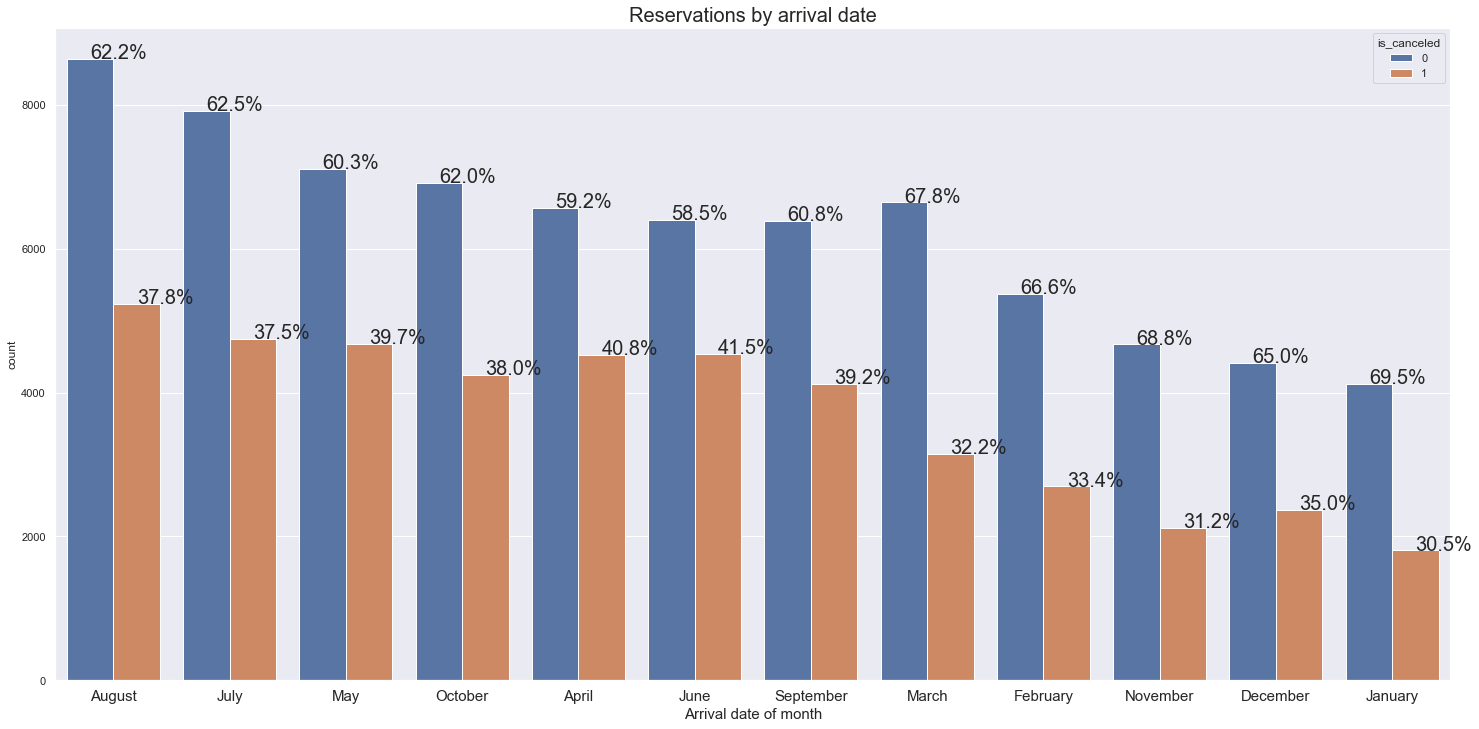

In [61]:
graphic = sns.countplot(data=df4, x='arrival_date_month', hue='is_canceled', order=df4['arrival_date_month'].value_counts().index)
plt.title('Reservations by arrival date', fontdict = {'fontsize':20})
plt.xlabel('Arrival date of month', fontsize=15)
with_hue(graphic, df4['arrival_date_month'], 12, 2)

### **H04** - Reservations made by families with babies are more likely to be canceled

*False*, the percentage of reservations canceled by families with babies is lower

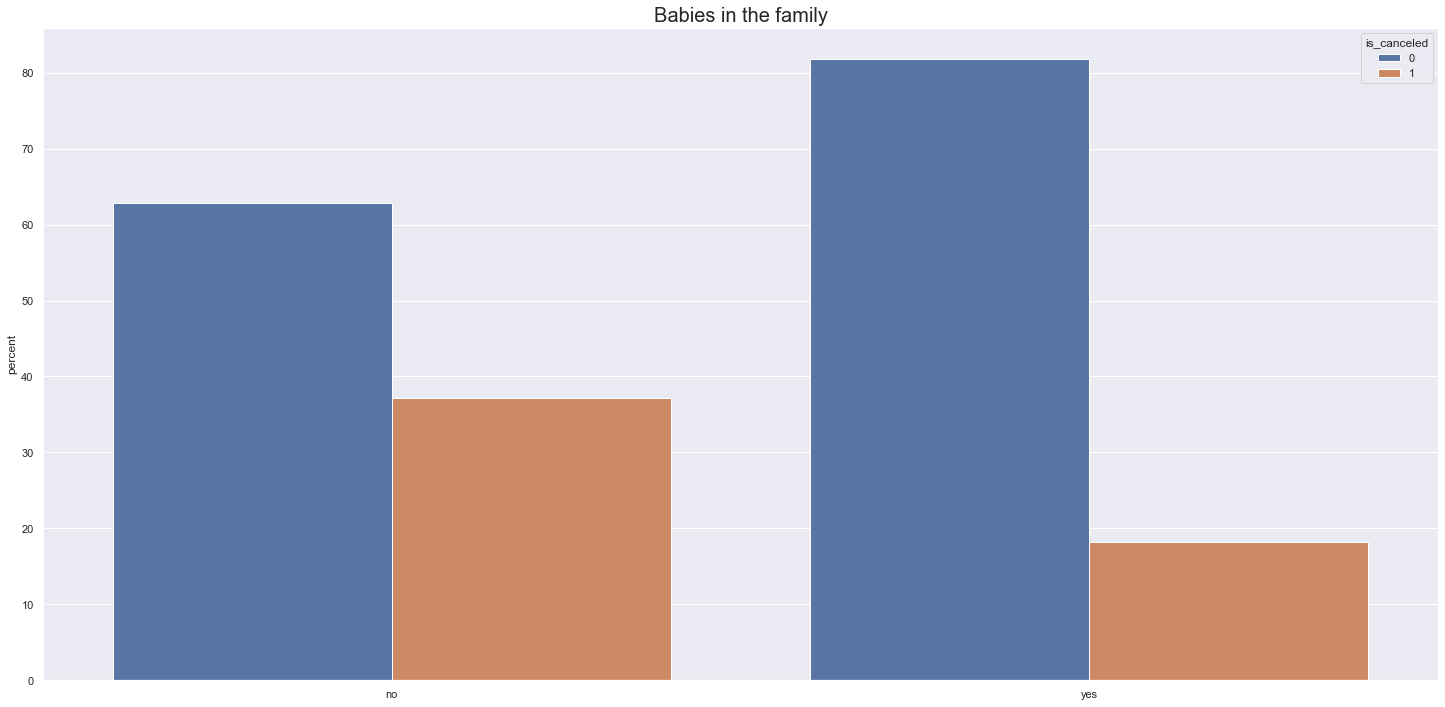

In [62]:
df_aux = df4[['babies', 'is_canceled']].copy()
df_aux['babies'] = df_aux['babies'].apply(lambda x: 'no' if x == 0 else 'yes')

graphic = (df_aux.groupby('babies')['is_canceled'].value_counts(normalize=True).mul(100).rename('percent').reset_index())

aux = sns.barplot(data = graphic, x = 'babies', y = 'percent', hue ='is_canceled')
plt.title('Babies in the family', fontdict = {'fontsize':20});
aux.set(xlabel=None);

### **H05** - Reservations made by the market segment group are less likely to be canceled

*True*, group is the only market segmentation in which the number of canceled reservations is more than half.

In [63]:
df4.groupby('market_segment')['is_canceled'].value_counts(normalize=True).mul(100).rename('percent').reset_index()


,market_segment,is_canceled,percent
0,Aviation,0,78.059072
1,Aviation,1,21.940928
2,Complementary,0,86.944818
3,Complementary,1,13.055182
4,Corporate,0,81.265345
5,Corporate,1,18.734655
6,Direct,0,84.658099
7,Direct,1,15.341901
8,Groups,1,61.062036
9,Groups,0,38.937964


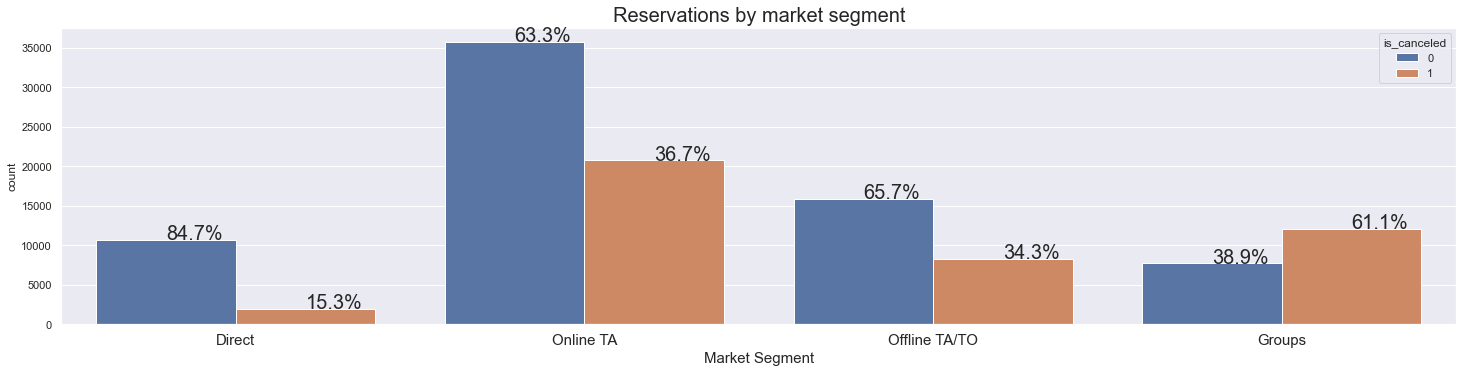

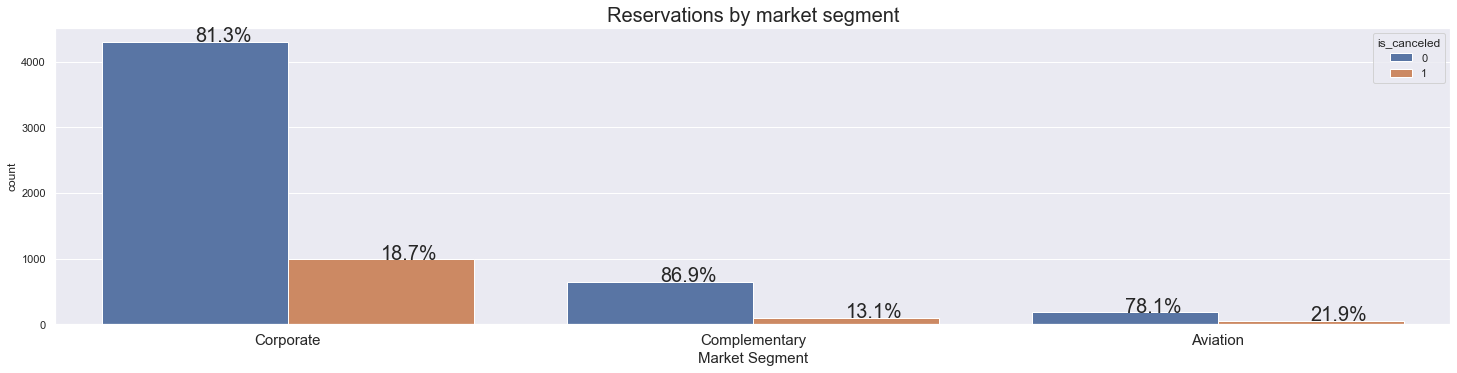

In [64]:

df_aux = df4[(df4['market_segment'] == 'Online TA') | (df4['market_segment'] == 'Offline TA/TO') |
             (df4['market_segment'] == 'Groups') | (df4['market_segment'] == 'Direct')]

df_aux1 = df4[(df4['market_segment'] == 'Corporate') | (df4['market_segment'] == 'Complementary') | (df4['market_segment'] == 'Aviation')]

plt.subplot(2, 1, 1)
graphic = sns.countplot(data=df_aux, x='market_segment', hue='is_canceled')
plt.title('Reservations by market segment', fontdict = {'fontsize':20})
plt.xlabel('Market Segment', fontsize=15)
with_hue(graphic, df4['market_segment'], 4, 2)

plt.subplot(2, 1, 2)
graphic = sns.countplot(data=df_aux1, x='market_segment', hue='is_canceled')
plt.title('Reservations by market segment', fontdict = {'fontsize':20})
plt.xlabel('Market Segment', fontsize=15)
with_hue(graphic, df4['market_segment'], 3, 2)

### **H06** - Reservations made by customers who have already used the services are less likely to be canceled

*True*, the percentage of canceled reservations is higher by new customers

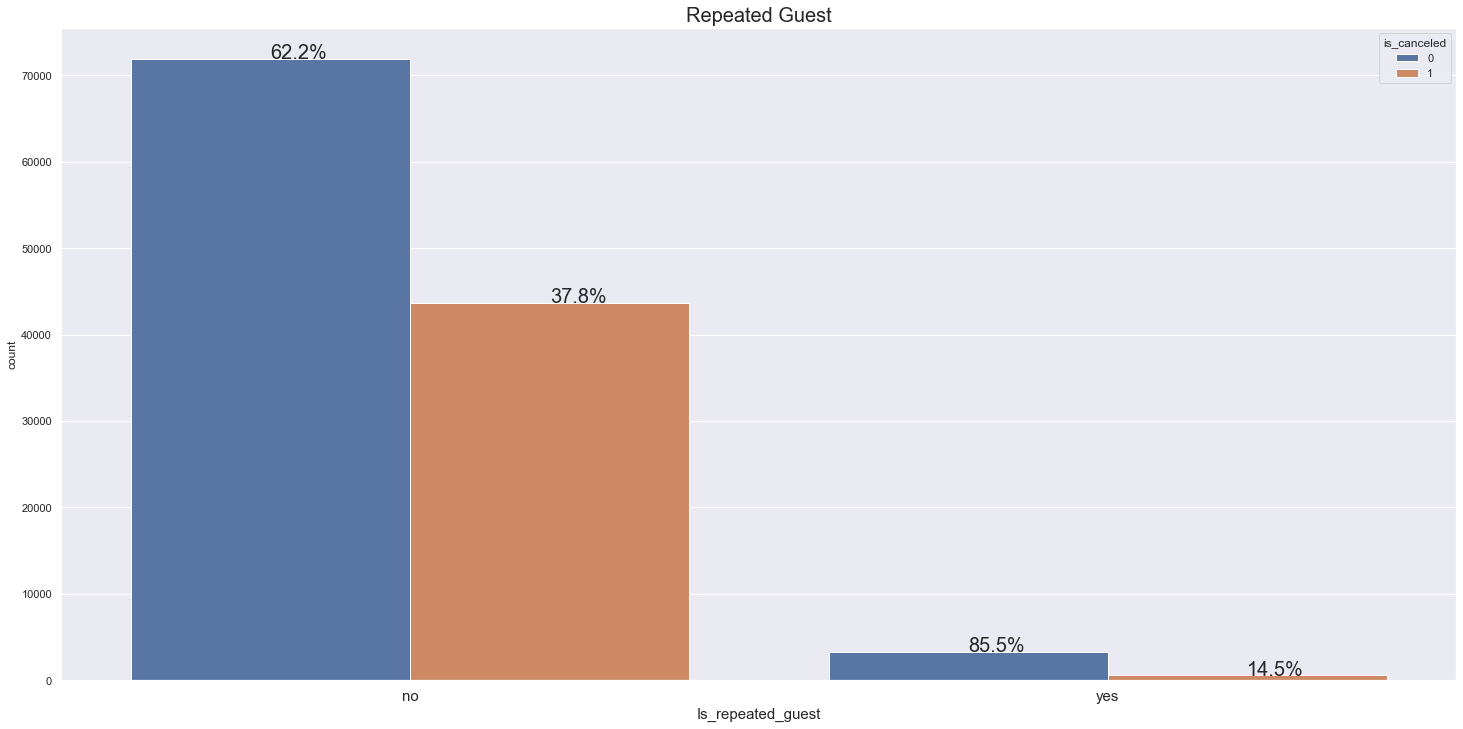

In [65]:
df_aux = df4[['is_repeated_guest', 'is_canceled']].copy()
df_aux['is_repeated_guest'] = df_aux['is_repeated_guest'].apply(lambda x: 'no' if x == 0 else 'yes')

graphic = sns.countplot(data=df_aux, x='is_repeated_guest', hue='is_canceled')
plt.title('Repeated Guest', fontdict = {'fontsize':20})
plt.xlabel('Is_repeated_guest', fontsize=15)
with_hue(graphic, df_aux['is_repeated_guest'], 2, 2)

### **H07** - Customers who have previously canceled reservations are more likely to cancel again

*True*, 91.6% of reservations made by customers who have previously canceled reservations have also been canceled

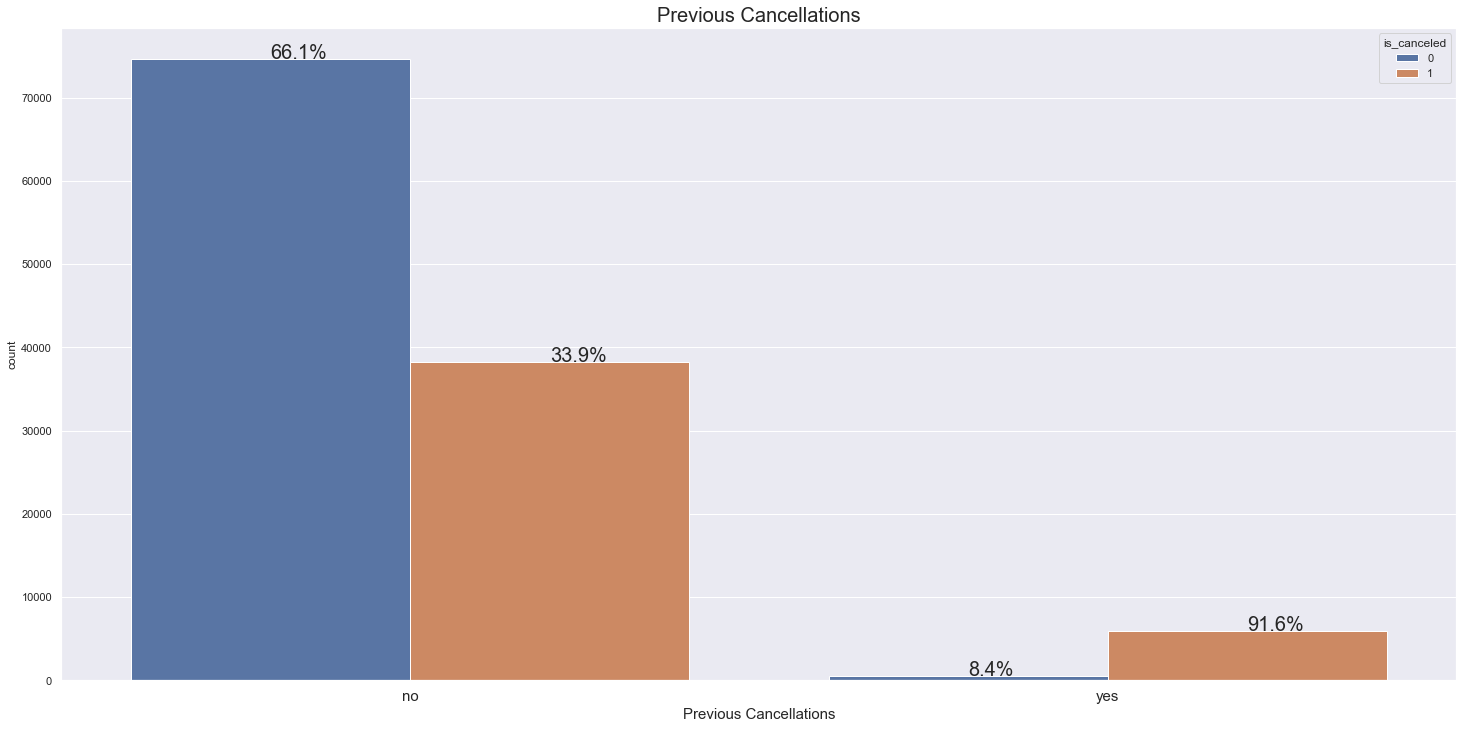

In [66]:
df_aux = df4[['previous_cancellations', 'is_canceled']].copy()
df_aux['previous_cancellations'] = df_aux['previous_cancellations'].apply(lambda x: 'no' if x == 0 else 'yes')

graphic = sns.countplot(data=df_aux, x='previous_cancellations', hue='is_canceled')
plt.title('Previous Cancellations', fontdict = {'fontsize':20})
plt.xlabel('Previous Cancellations', fontsize=15)
with_hue(graphic, df_aux['previous_cancellations'], 2, 2)

### **H08** - The greater the number of previous uncanceled reservations made by a customer, the less likely their future reservations are to be canceled.

*True*, the percentage of canceled reservations drops from 38% to 5.5% when made by customers who have already had an uncanceled reservation.

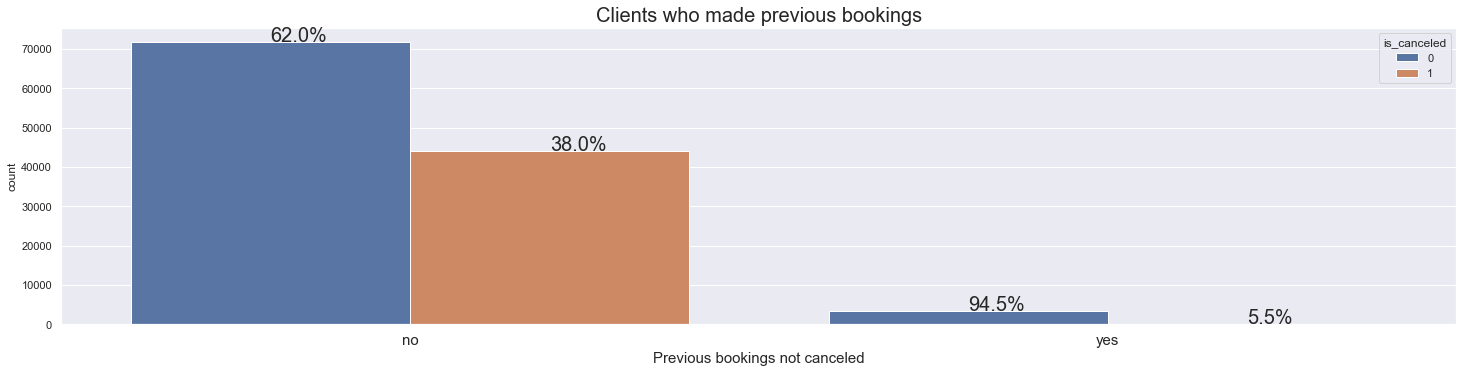

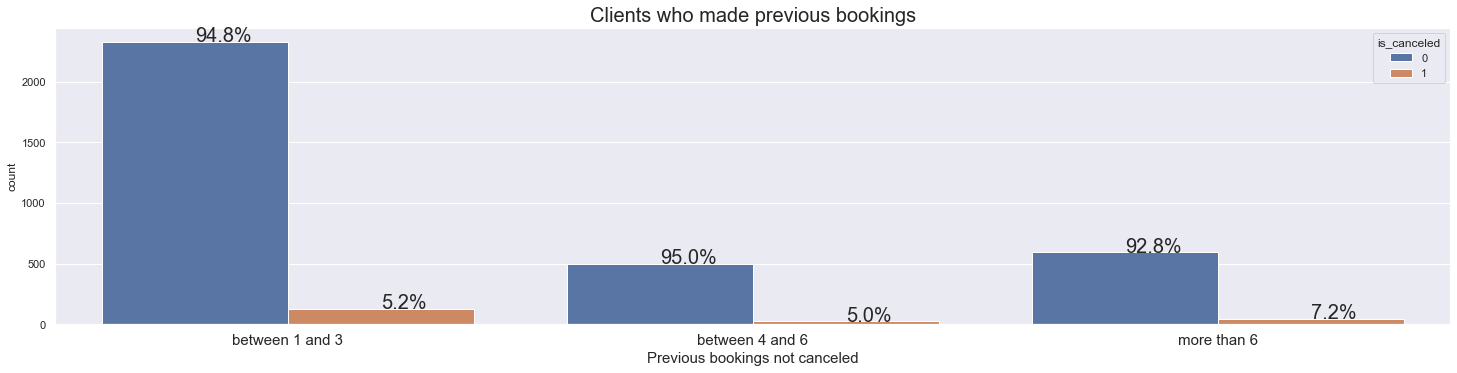

In [67]:
df_aux = df4[['previous_bookings_not_canceled', 'is_canceled']].copy()
df_aux['previous_bookings_not_canceled'] = df_aux['previous_bookings_not_canceled'].apply(lambda x: 'no' if x == 0 else 'yes')

df_aux1 = df4[df4['previous_bookings_not_canceled'] > 0].copy()

df_aux1['previous_bookings_not_canceled'] = df_aux1['previous_bookings_not_canceled'].apply(lambda x: 'between 1 and 3' if x < 4
                                               else 'between 4 and 6' if (x>3)&(x<7)
                                               else 'more than 6')

plt.subplot(2, 1, 1)
graphic = sns.countplot(data=df_aux, x='previous_bookings_not_canceled', hue='is_canceled')
plt.title('Clients who made previous bookings', fontdict = {'fontsize':20})
plt.xlabel('Previous bookings not canceled', fontsize=15)
with_hue(graphic, df_aux['previous_bookings_not_canceled'], 2, 2)

plt.subplot(2, 1, 2)
graphic = sns.countplot(data=df_aux1, x='previous_bookings_not_canceled', hue='is_canceled')
plt.title('Clients who made previous bookings', fontdict = {'fontsize':20})
plt.xlabel('Previous bookings not canceled', fontsize=15)
with_hue(graphic, df_aux1['previous_bookings_not_canceled'], 3, 2)

### **H09** - The percentage of canceled reservations is higher when the room type assigned is different from the room type reserved

*False*, when the room assigned was different from the room reserved the percentage of canceled reservations was only 5.4%

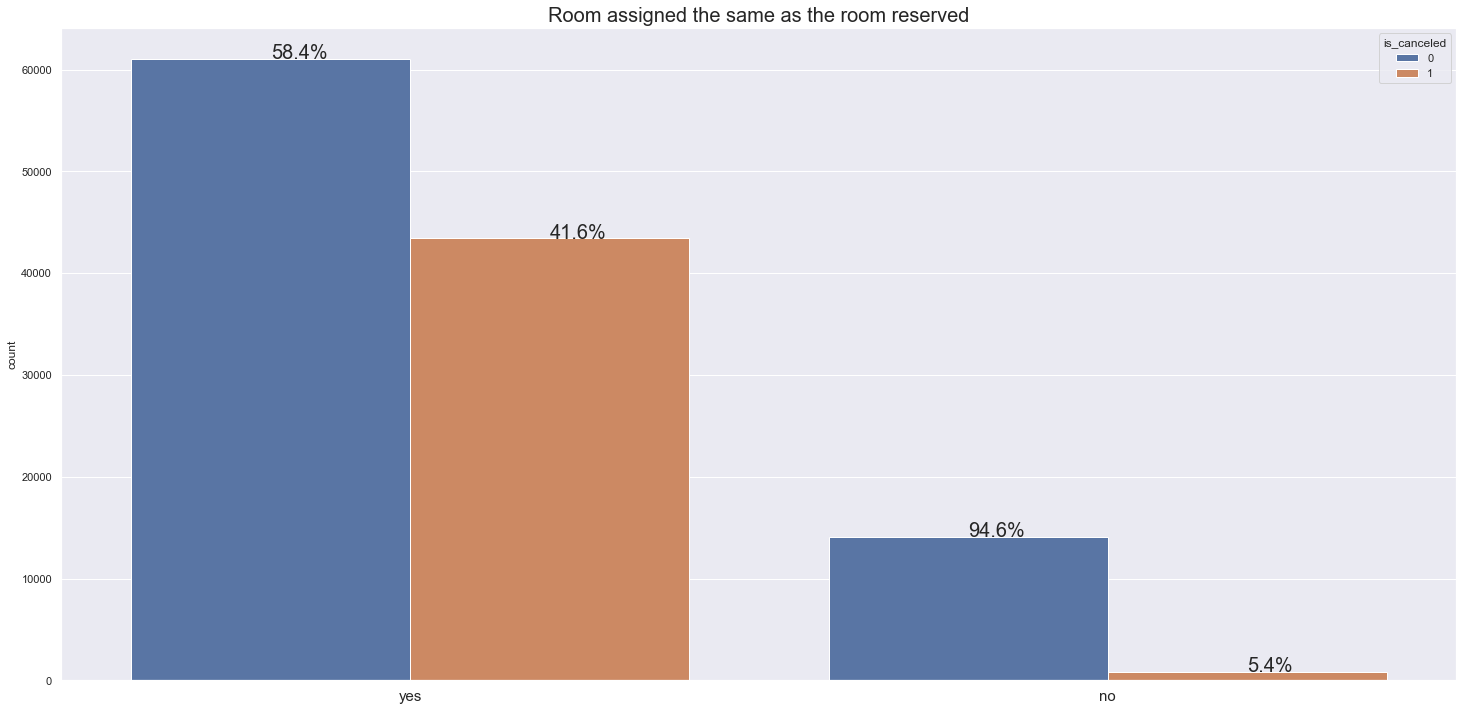

In [68]:
df_aux = df4[['assigned_reserved', 'is_canceled']].copy()
df_aux['assigned_reserved'] = df_aux['assigned_reserved'].apply(lambda x: 'no' if x == 0 else 'yes')

graphic = sns.countplot(data=df_aux, x='assigned_reserved', hue='is_canceled')
plt.title('Room assigned the same as the room reserved', fontdict = {'fontsize':20})
graphic.set(xlabel=None);
with_hue(graphic, df_aux['assigned_reserved'], 2, 2)

### **H10** - Customers who do not make changes or amendments to their booking are less likely to cancel their reservations

*False*, when booking changes were not requested, the percentage of canceled reservations was higher.

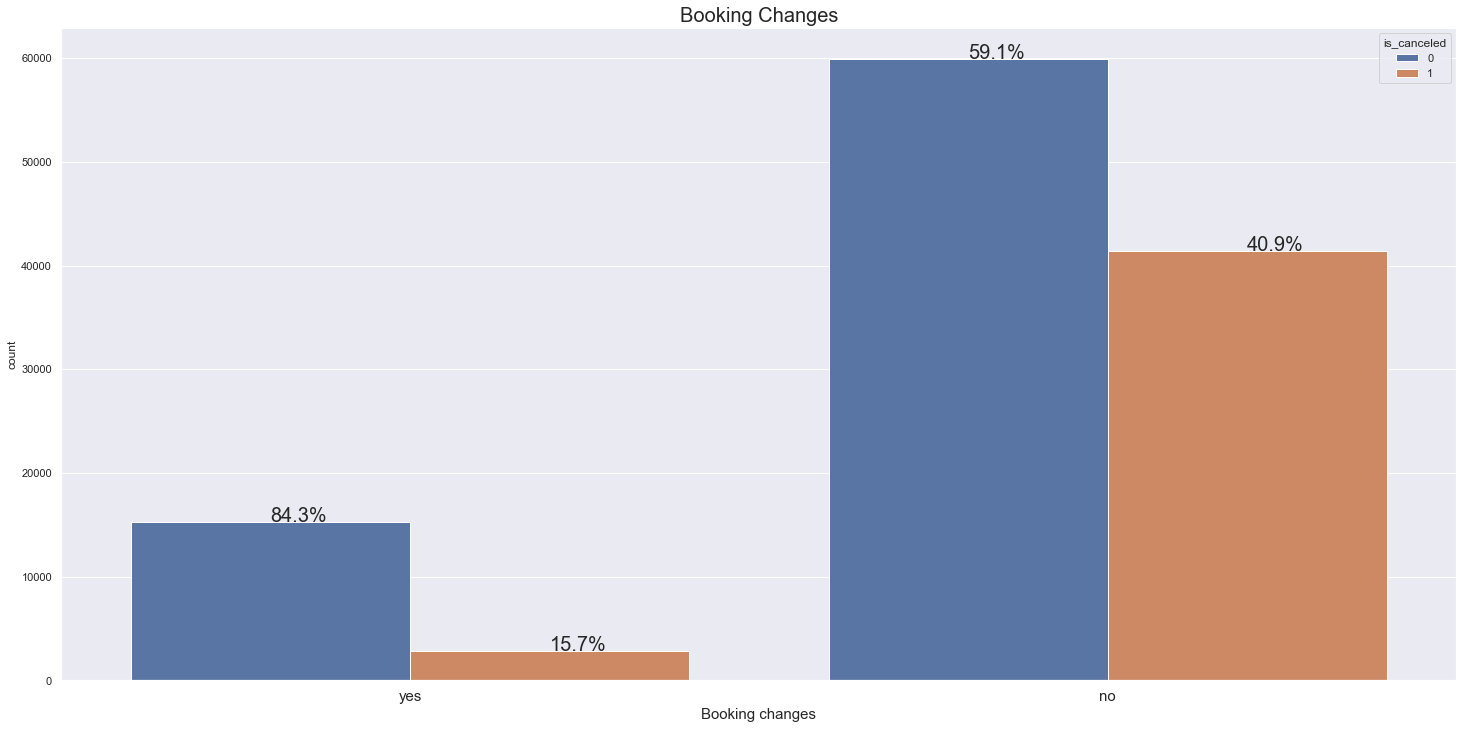

In [69]:
df_aux = df4[['booking_changes', 'is_canceled']].copy()
df_aux['booking_changes'] = df_aux['booking_changes'].apply(lambda x: 'no' if x == 0 else 'yes')

graphic = sns.countplot(data = df_aux, x='booking_changes', hue='is_canceled')
plt.title('Booking Changes', fontdict = {'fontsize':20})
plt.xlabel('Booking changes', fontsize=15)
with_hue(graphic, df_aux['booking_changes'], 2, 2)

### **H11** - The probability of canceled reservations is lower after the deposit was made

*False*, the percentage of reservations canceled is higher when is made a deposit to guarantee the booking. For reservations that had a deposit with the value of the total stay cost, almost all, 98.5% was canceled.

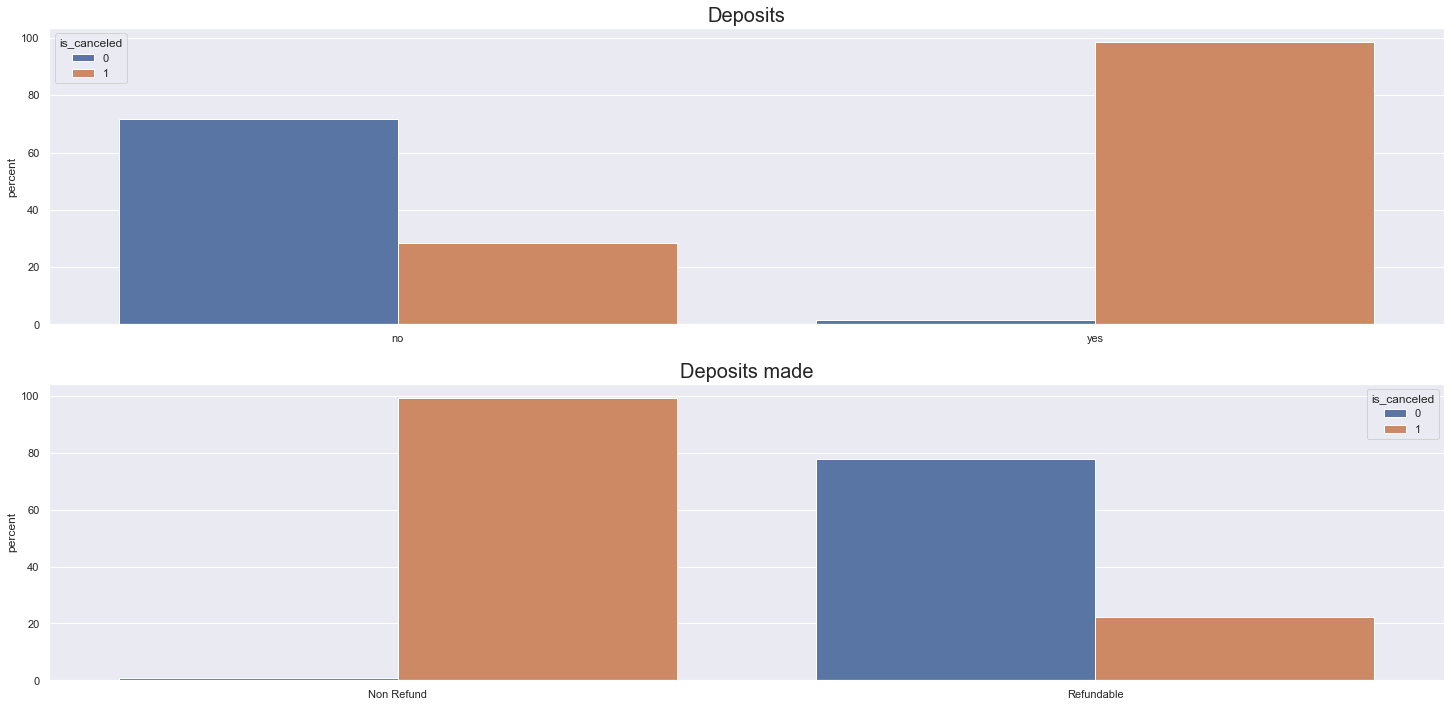

In [70]:
df_aux = df4[['deposit_type', 'is_canceled']].copy()
df_aux['deposit_type'] = df_aux['deposit_type'].apply(lambda x: 'no' if x == 'No Deposit' else 'yes')

df_aux1 = df4[df4['deposit_type']!='No Deposit']

plt.subplot(2, 1, 1)
graphic = (df_aux.groupby('deposit_type')['is_canceled'].value_counts(normalize=True).mul(100).rename('percent').reset_index())
aux = sns.barplot(data = graphic, x = 'deposit_type', y = 'percent', hue ='is_canceled')
plt.title('Deposits', fontdict = {'fontsize':20});
aux.set(xlabel=None);


plt.subplot(2, 1, 2)
graphic = (df_aux1.groupby('deposit_type')['is_canceled'].value_counts(normalize=True).mul(100).rename('percent').reset_index())
aux = sns.barplot(data = graphic, x = 'deposit_type', y = 'percent', hue ='is_canceled')
plt.title('Deposits made', fontdict = {'fontsize':20});
aux.set(xlabel=None);

### **H12** - Reservations made by companies or entities are less likely to be canceled

*True*, the percentage of reservations canceled when payment was made by a company or entity is lower

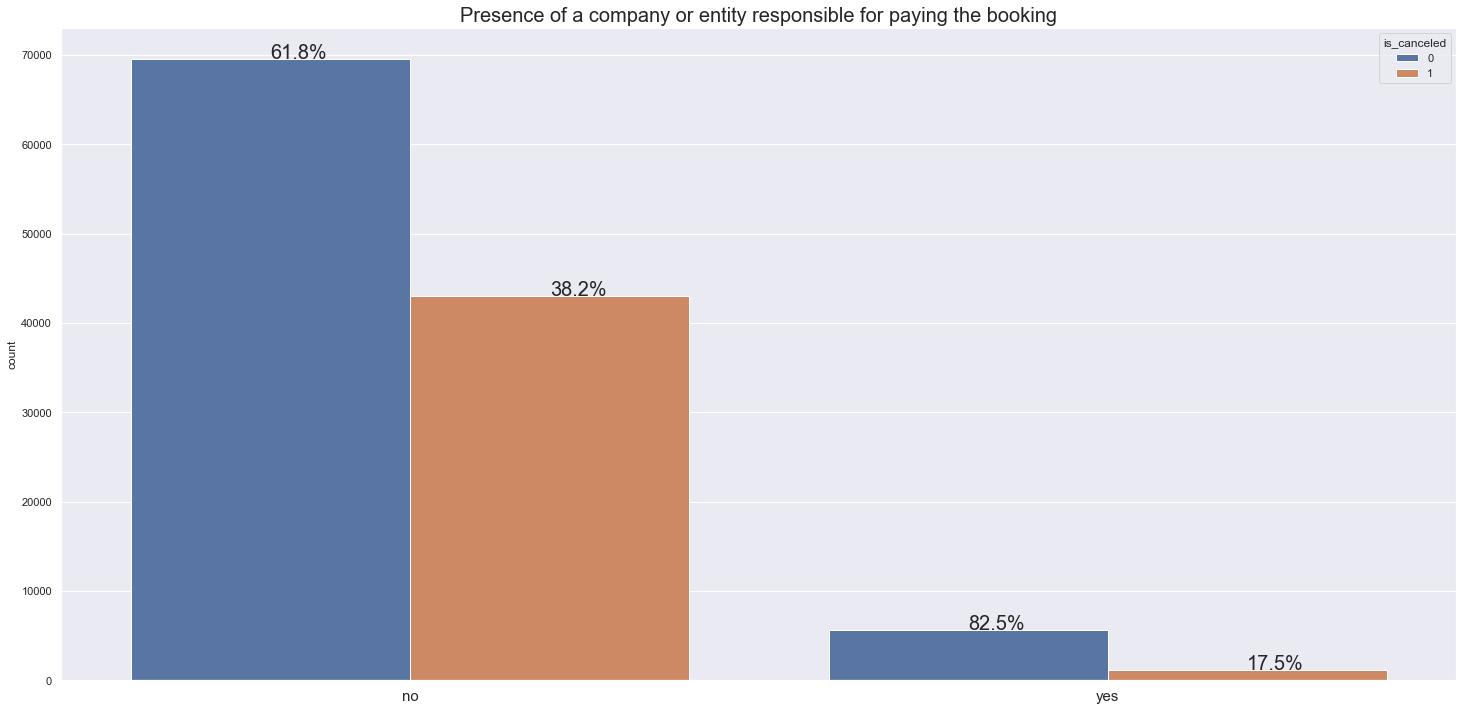

In [71]:
df_aux = df4[['company', 'is_canceled']].copy()
df_aux['company'] = df_aux['company'].apply(lambda x: 'no' if x == 0 else 'yes')

graphic = sns.countplot(data=df_aux, x='company', hue='is_canceled')
plt.title('Presence of a company or entity responsible for paying the booking', fontdict = {'fontsize':20})
graphic.set(xlabel=None);
with_hue(graphic, df_aux['company'], 2, 2)

### **H13** - The greater the number of days on the waiting list, the more likely the reservation is to be canceled

*False*, the percentage of reservations canceled by customers who were on the waiting list is higher, but it is even higher when they have been in a short period of time.

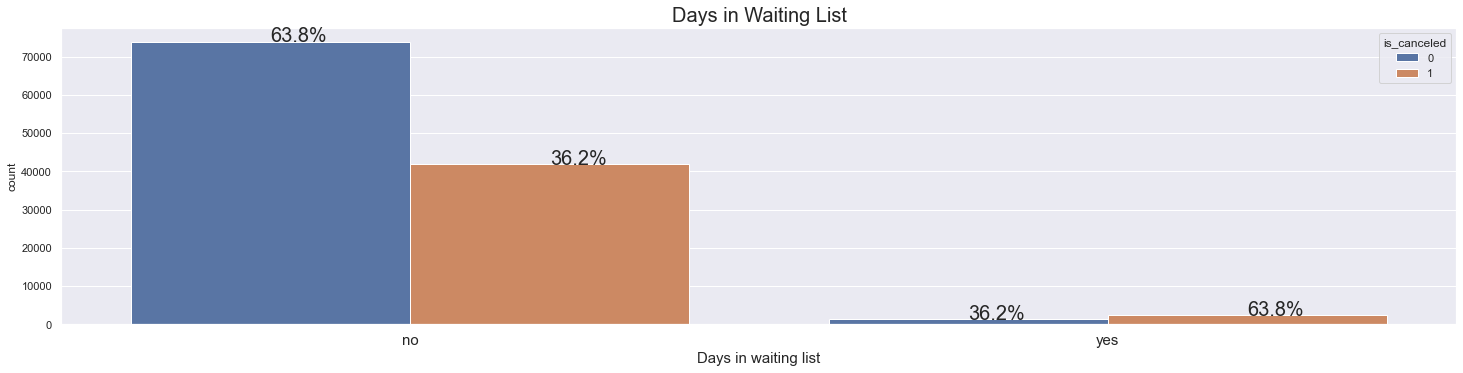

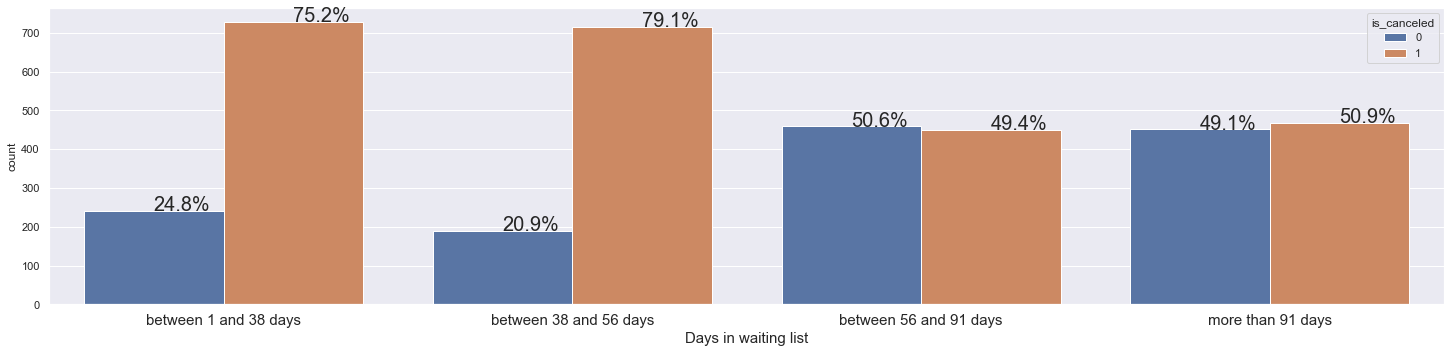

In [72]:
df_aux = df4[df4['days_in_waiting_list']>0].copy()

list1 = []
for i in range(1, 5):
    aux = df_aux['days_in_waiting_list'].quantile(i*0.25)
    list1.append(aux)

df_aux['days_in_waiting_list'] = df_aux['days_in_waiting_list'].apply(lambda x: 'between 1 and 38 days' if x <= list1[0] 
                                                                        else 'between 38 and 56 days'   if (x > list1[0]) & (x <= list1[1])
                                                                        else 'between 56 and 91 days'   if (x > list1[1]) & (x <= list1[2])
                                                                        else 'more than 91 days')

df_aux2 = df4[['days_in_waiting_list', 'is_canceled']].copy()
df_aux2['days_in_waiting_list'] = df_aux2['days_in_waiting_list'].apply(lambda x: 'no' if x == 0 else 'yes')

plt.subplot(2, 1, 1)
graphic = sns.countplot(data=df_aux2, x='days_in_waiting_list', hue='is_canceled')
plt.title('Days in Waiting List', fontdict = {'fontsize':20})
plt.xlabel('Days in waiting list', fontsize=15)
with_hue(graphic, df_aux2['days_in_waiting_list'], 2, 2)

plt.subplot(2, 1, 2)
graphic = sns.countplot(data=df_aux, x='days_in_waiting_list', hue='is_canceled', order = ('between 1 and 38 days' , 'between 38 and 56 days', 
                                                                                           'between 56 and 91 days',  'more than 91 days'))
plt.xlabel('Days in waiting list', fontsize=15)
with_hue(graphic, df_aux['days_in_waiting_list'], 4, 2);



### **H14** - The greater the number of special requests, the more likely the reservation is to be canceled

*False*, the greater the number of special requests, the lower the percentage of canceled reservations

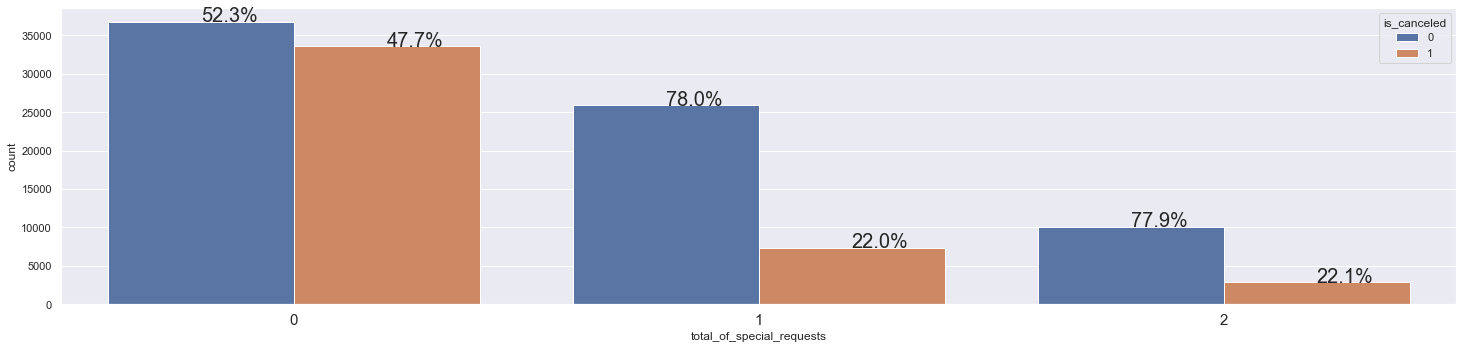

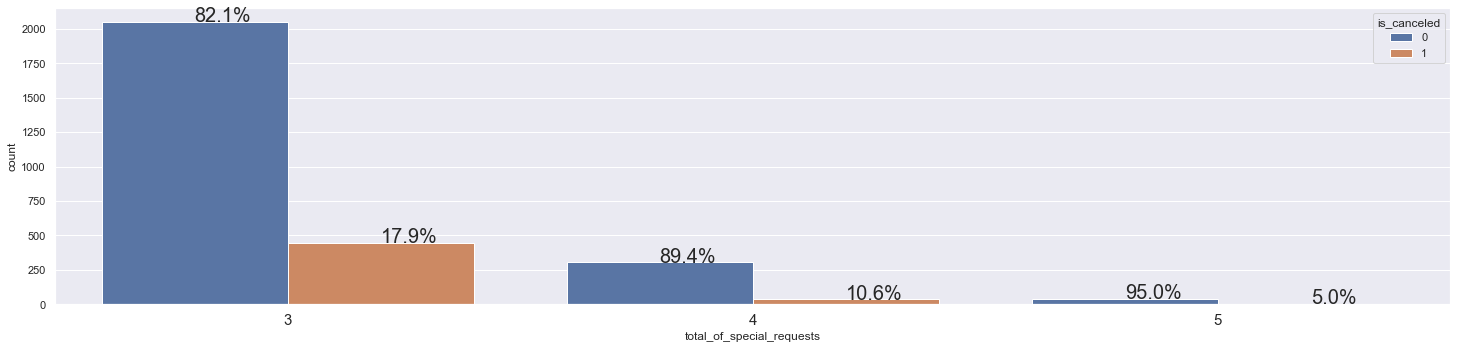

In [73]:
df_aux = df4[df4['total_of_special_requests'] < 3]
df_aux1 = df4[df4['total_of_special_requests'] >=3]

plt.subplot(2, 1, 1)
graphic = sns.countplot(data=df_aux, x='total_of_special_requests', hue='is_canceled')
with_hue(graphic, df_aux['total_of_special_requests'], 3, 2)

plt.subplot(2, 1, 2)
graphic = sns.countplot(data=df_aux1, x='total_of_special_requests', hue='is_canceled')
with_hue(graphic, df_aux1['total_of_special_requests'], 3, 2)

# 5.0 Data Preparation

In [74]:
df5 = df4.copy()

## 5.1 Label Encoding

In [75]:
le = LabelEncoder()

df5['hotel'] = le.fit_transform(df5['hotel'])

df5['arrival_date_year'] = le.fit_transform(df5['arrival_date_year'])

df5['meal'] = le.fit_transform(df5['meal'])

df5['market_segment'] = le.fit_transform(df5['market_segment'])

df5['distribution_channel'] = le.fit_transform(df5['distribution_channel'])

df5['deposit_type'] = le.fit_transform(df5['deposit_type'])

df5['customer_type'] = le.fit_transform(df5['customer_type'])

## 5.2 Frequency Encoding

In [76]:
fe_country = df5['country'].value_counts(normalize=True)
df5.loc[:, 'country'] = df5['country'].map(fe_country)

fe_agent = df5['agent'].value_counts(normalize=True)
df5.loc[:, 'agent'] = df5['agent'].map(fe_agent)

fe_company = df5['company'].value_counts(normalize=True)
df5.loc[:, 'company'] = df5['company'].map(fe_company)

fe_reserved = df5['reserved_room_type'].value_counts(normalize=True)
df5.loc[:, 'reserved_room_type'] = df5['reserved_room_type'].map(fe_reserved)

fe_assigned = df5['assigned_room_type'].value_counts(normalize=True)
df5.loc[:, 'assigned_room_type'] = df5['assigned_room_type'].map(fe_assigned)

## 5.3 Robust Scaler

In [77]:
rs = RobustScaler()

df5['lead_time'] = rs.fit_transform(df5[['lead_time']].values)

df5['stays_in_weekend_nights'] = rs.fit_transform(df5[['stays_in_weekend_nights']].values)

df5['stays_in_week_nights'] = rs.fit_transform(df5[['stays_in_week_nights']].values)

df5['previous_cancellations'] = rs.fit_transform(df5[['previous_cancellations']].values)

df5['previous_bookings_not_canceled'] = rs.fit_transform(df5[['previous_bookings_not_canceled']].values)

df5['booking_changes'] = rs.fit_transform(df5[['booking_changes']].values)

df5['days_in_waiting_list'] = rs.fit_transform(df5[['days_in_waiting_list']].values)

df5['adr'] = rs.fit_transform(df5[['adr']].values)

## 5.4 Min Max Scaler

In [78]:
mms = MinMaxScaler()

df5['adults'] = mms.fit_transform(df5[['adults']].values)

df5['children'] = mms.fit_transform(df5[['children']].values)

df5['babies'] = mms.fit_transform(df5[['babies']].values)

df5['required_car_parking_spaces'] = mms.fit_transform(df5[['required_car_parking_spaces']].values)

df5['total_of_special_requests'] = mms.fit_transform(df5[['total_of_special_requests']].values)

## 5.5 Cyclic Transformation

In [79]:
# arrival_date_week_number
df5['arrival_date_week_number_sin'] = df5['arrival_date_week_number'].apply(lambda x: np.sin(x*(2*np.pi/53)))
df5['arrival_date_week_number_cos'] = df5['arrival_date_week_number'].apply(lambda x: np.cos(x*(2*np.pi/53)))


# arrival_date_day_of_month
month_list = {'January':0 , 'February':2, 'March': 0, 'April':1, 'May':0, 'June':1, 'July': 0,
           'August':0, 'September':1, 'October': 0, 'November':1, 'December':0 }

df5['aux'] = df5['arrival_date_month'].map(month_list)

auxi=[]
for i in range(0, 2):
    df_aux = df5.loc[df5['aux']==i]
    maxx = df_aux['arrival_date_day_of_month'].max()
    ind = df_aux.index
    df5.loc[ind, 'arrival_date_day_of_month_sin'] = np.sin(df5['arrival_date_day_of_month']*2*np.pi/maxx)
    df5.loc[ind, 'arrival_date_day_of_month_cos'] = np.cos(df5['arrival_date_day_of_month']*2*np.pi/maxx)
    

lista_aux=[]    
for i in range (1, 3):
    df_aux = df5.loc[(df5['aux']==2) & (df5['arrival_date_year']==i)]
    maxx = df_aux['arrival_date_day_of_month'].max()
    lista_aux.append(maxx)
    ind = df_aux.index
    df5.loc[ind, 'arrival_date_day_of_month_sin'] = np.sin(df5['arrival_date_day_of_month']*2*np.pi/maxx)
    df5.loc[ind, 'arrival_date_day_of_month_cos'] = np.cos(df5['arrival_date_day_of_month']*2*np.pi/maxx)

# arrival_date_day_of_month
month_list = {'January':1 , 'February':2, 'March': 3, 'April':4, 'May':5, 'June':6, 'July': 7,
           'August':8, 'September':9, 'October': 10, 'November':11, 'December':12 }

df5['arrival_date_month'] = df5['arrival_date_month'].map(month_list)

df5['arrival_date_month_sin'] = df5['arrival_date_month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['arrival_date_month_cos'] = df5['arrival_date_month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

In [80]:
df5 = df5.drop(['arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'reservation_status_date', 'aux', 'reservation_status'], axis=1)

In [81]:
df5.head()

,hotel,is_canceled,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,assigned_reserved,arrival_date_week_number_sin,arrival_date_week_number_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_date_month_sin,arrival_date_month_cos
0,1,0,1.922535,0,-0.5,-1.0,0.036364,0.0,0.0,0,0.406986,3,1,0,0.0,0.0,0.007806,0.019893,3.0,0,0.136862,0.943069,0.0,2,-1.667695,0.0,0.0,1,-0.059241,-0.998244,0.201299,0.97953,-0.5,-0.866025
1,1,0,4.704225,0,-0.5,-1.0,0.036364,0.0,0.0,0,0.406986,3,1,0,0.0,0.0,0.007806,0.019893,4.0,0,0.136862,0.943069,0.0,2,-1.667695,0.0,0.0,1,-0.059241,-0.998244,0.201299,0.97953,-0.5,-0.866025
2,1,0,-0.436620,0,-0.5,-0.5,0.018182,0.0,0.0,0,0.101591,3,1,0,0.0,0.0,0.720278,0.019893,0.0,0,0.136862,0.943069,0.0,2,-0.345177,0.0,0.0,0,-0.059241,-0.998244,0.201299,0.97953,-0.5,-0.866025
3,1,0,-0.394366,0,-0.5,-0.5,0.018182,0.0,0.0,0,0.101591,2,0,0,0.0,0.0,0.720278,0.620261,0.0,0,0.000008,0.943069,0.0,2,-0.345177,0.0,0.0,1,-0.059241,-0.998244,0.201299,0.97953,-0.5,-0.866025
4,1,0,-0.387324,0,-0.5,0.0,0.036364,0.0,0.0,0,0.101591,6,3,0,0.0,0.0,0.720278,0.620261,0.0,0,0.116609,0.943069,0.0,2,0.060395,0.0,0.2,1,-0.059241,-0.998244,0.201299,0.97953,-0.5,-0.866025


# 6.0 Feature Selection

In [82]:
df6 = df5.copy()

## 6.1 Split into train and test

In [83]:
X = df6.drop(['is_canceled'], axis=1).copy()
y = df6[['is_canceled']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

## 6.2 Feature Importance

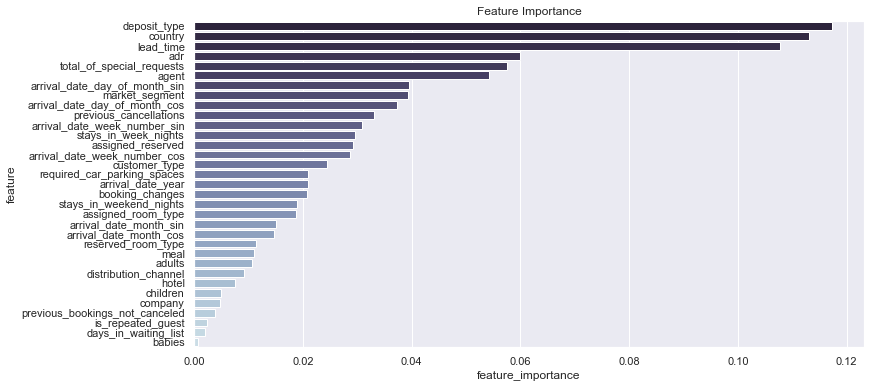

In [84]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', palette="ch:s=.25,rot=-.25_r")\
    .set_title('Feature Importance');

# 7.0 Machine Learning

In [85]:
models = pd.DataFrame()

## 7.1 KNN

  Model  accuracy  precision    recall  roc_auc_score  f1_score
0   KNN  0.808694   0.762941  0.701526       0.874117  0.730946


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

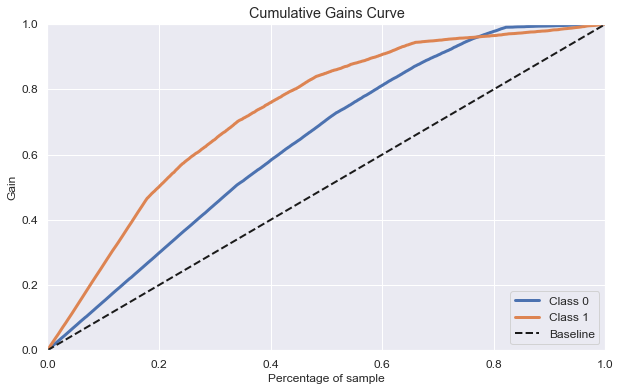

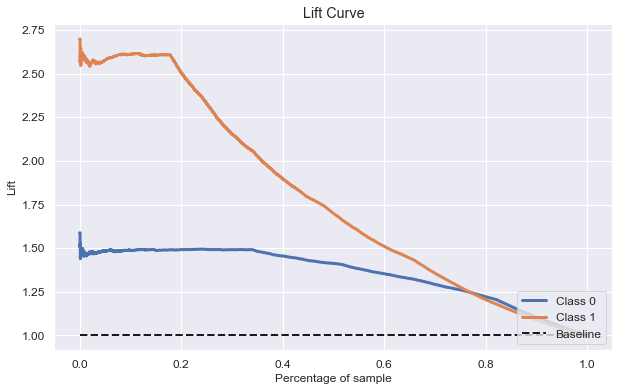

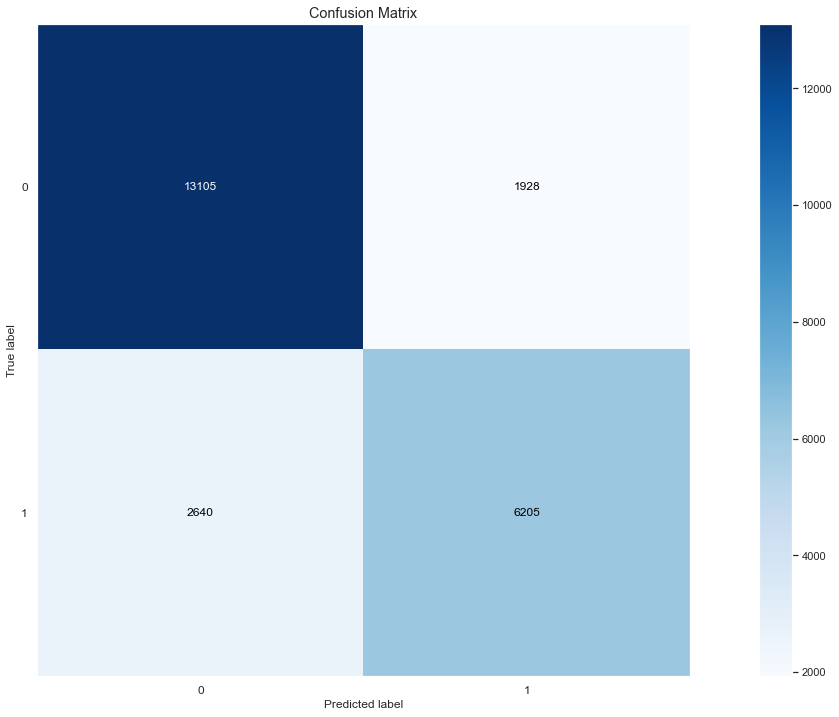

In [86]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

knn_model.fit(X_train, y_train.values.ravel())

yhat_knn = knn_model.predict_proba(X_test)


df_knn = pd.DataFrame(yhat_knn)
df_knn[2] = df_knn[1].apply(lambda x: 1 if x >=0.5 else 0)
df_knn[3] = y_test['is_canceled'].reset_index(drop=True)

mtr.plot_cumulative_gain(y_test, yhat_knn, figsize=(10,6))

mtr.plot_lift_curve(y_test, yhat_knn, figsize=(10,6))

metrics = metrics_score('KNN', df_knn)
models = models.append(metrics, ignore_index=True)

print(metrics)

mtr.plot_confusion_matrix(df_knn[3], df_knn[2])

## 7.2 Random Forest Classifier

           Model  accuracy  precision    recall  roc_auc_score  f1_score
0  Random Forest  0.896976   0.883299  0.831769       0.962098   0.85676


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

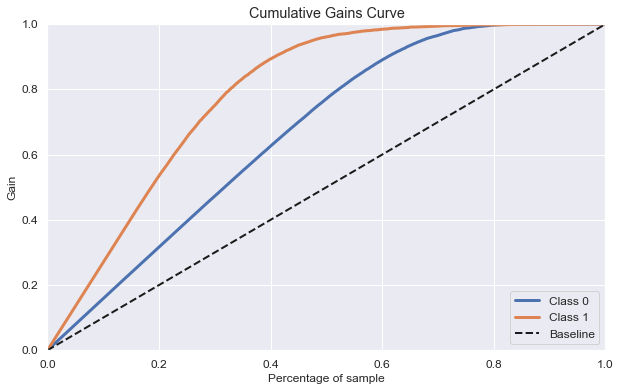

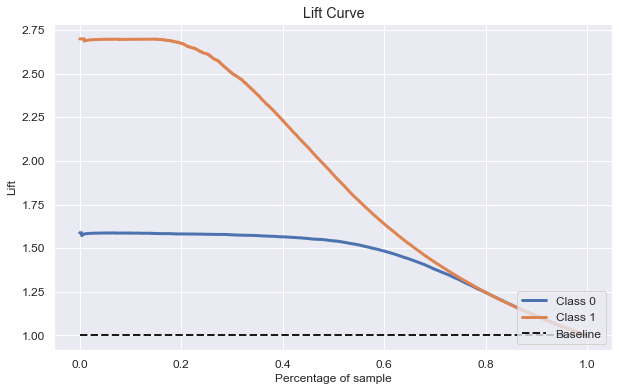

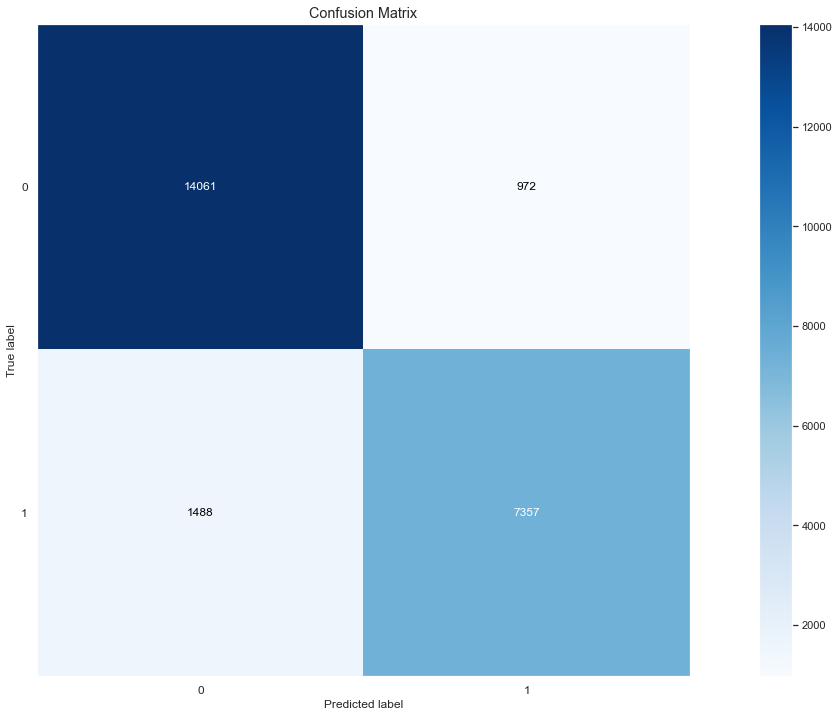

In [87]:
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

rf_model.fit(X_train, y_train.values.ravel())

yhat_rf = rf_model.predict_proba(X_test)

df_rf = pd.DataFrame(yhat_rf)
df_rf[2] = df_rf[1].apply(lambda x: 1 if x>=0.5 else 0)
df_rf[3] = y_test['is_canceled'].reset_index(drop=True)

mtr.plot_cumulative_gain(y_test, yhat_rf, figsize=(10, 6))

mtr.plot_lift_curve(y_test, yhat_rf, figsize=(10, 6))

metrics = metrics_score('Random Forest', df_rf)
models = models.append(metrics, ignore_index=True)

print(metrics)

mtr.plot_confusion_matrix(df_rf[3], df_rf[2])

## 7.3 Extra Tree Classifier

        Model  accuracy  precision    recall  roc_auc_score  f1_score
0  Extra Tree  0.891741   0.871999  0.829508       0.957241  0.850223


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

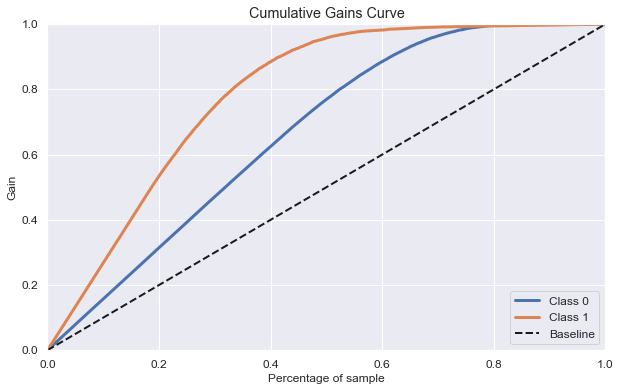

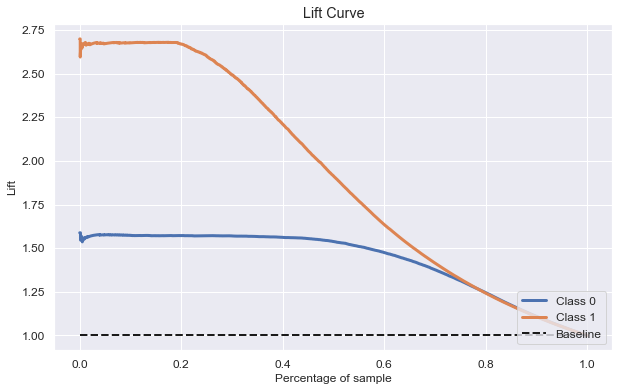

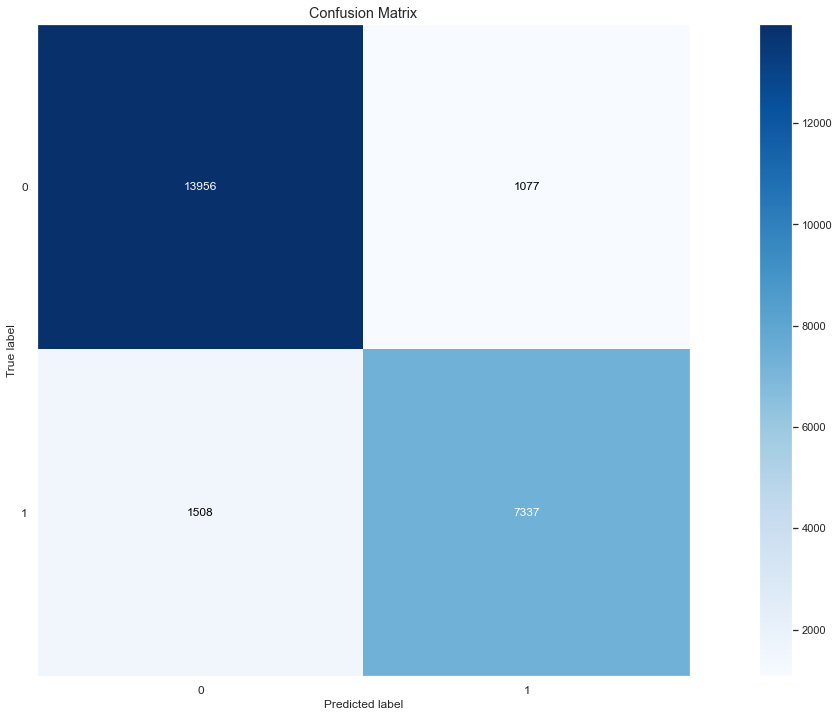

In [88]:
et_model = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

et_model.fit(X_train, y_train.values.ravel())

yhat_et = et_model.predict_proba(X_test)

df_et = pd.DataFrame(yhat_et)
df_et[2] = df_et[1].apply(lambda x: 1 if x>=0.5 else 0)
df_et[3] = y_test['is_canceled'].reset_index(drop=True)

mtr.plot_cumulative_gain(y_test, yhat_et, figsize=(10,6))

mtr.plot_lift_curve(y_test, yhat_et, figsize=(10,6))

metrics = metrics_score('Extra Tree', df_et)
models = models.append(metrics, ignore_index=True)

print(metrics)

mtr.plot_confusion_matrix(df_et[3], df_et[2])

## 7.4 XG Boost

      Model  accuracy  precision    recall  roc_auc_score  f1_score
0  XG Boost  0.883365   0.860543  0.817637       0.954911  0.838541


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

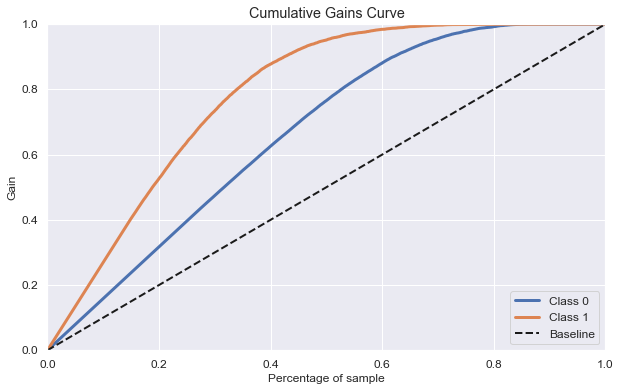

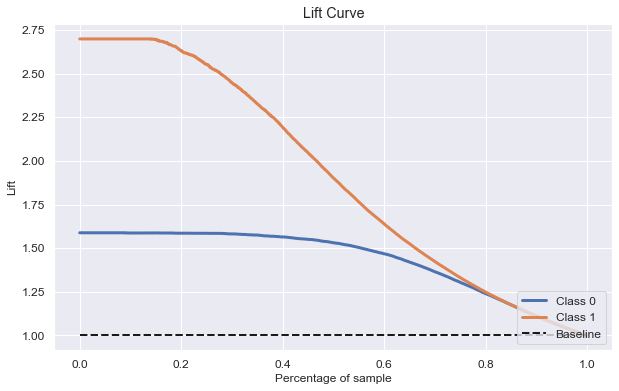

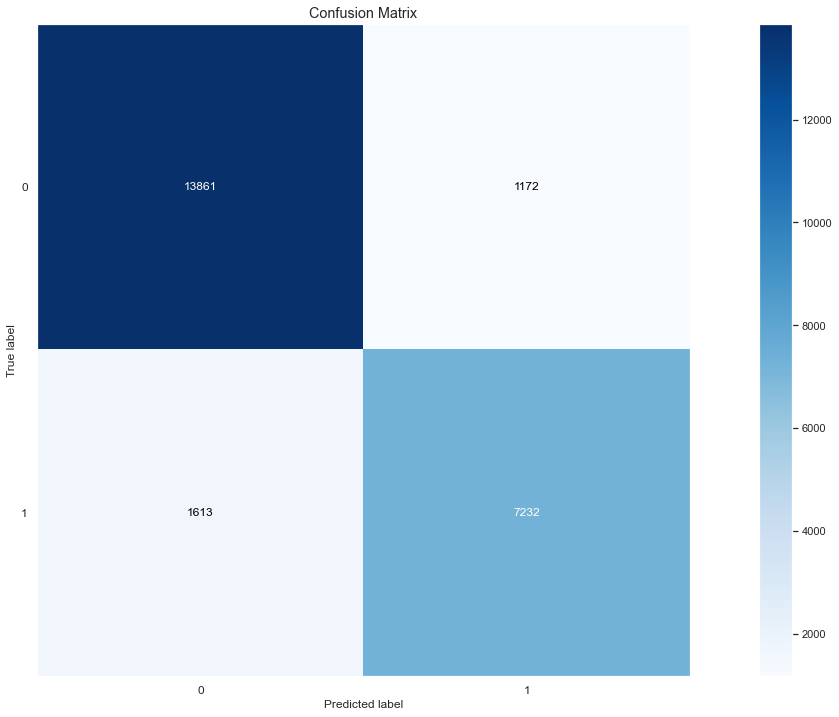

In [89]:
xgb_model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train.values.ravel())

yhat_xgb = xgb_model.predict_proba(X_test)

df_xgb = pd.DataFrame(yhat_xgb)
df_xgb[2] = df_xgb[1].apply(lambda x: 1 if x>=0.5 else 0)
df_xgb[3] = y_test['is_canceled'].reset_index(drop=True)

mtr.plot_cumulative_gain(y_test, yhat_xgb, figsize=(10,6))

mtr.plot_lift_curve(y_test, yhat_xgb, figsize=(10,6))

metrics = metrics_score('XG Boost', df_xgb)
models = models.append(metrics, ignore_index=True)

print(metrics)

mtr.plot_confusion_matrix(df_xgb[3], df_xgb[2])

## 7.5 LGBM Classifier

  Model  accuracy  precision   recall  roc_auc_score  f1_score
0  LGBM  0.878047   0.858663  0.80294       0.951921  0.829867


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

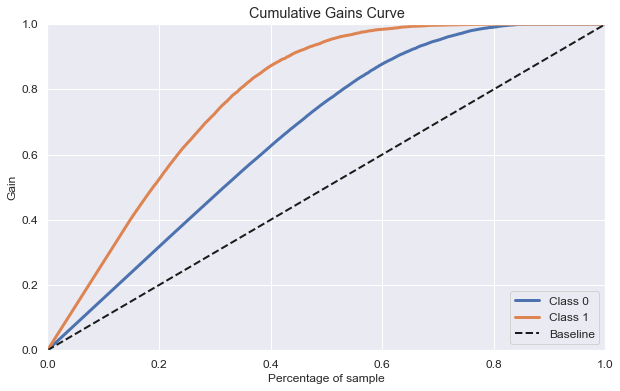

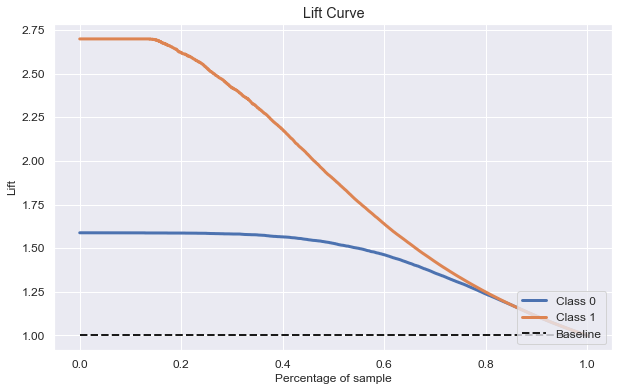

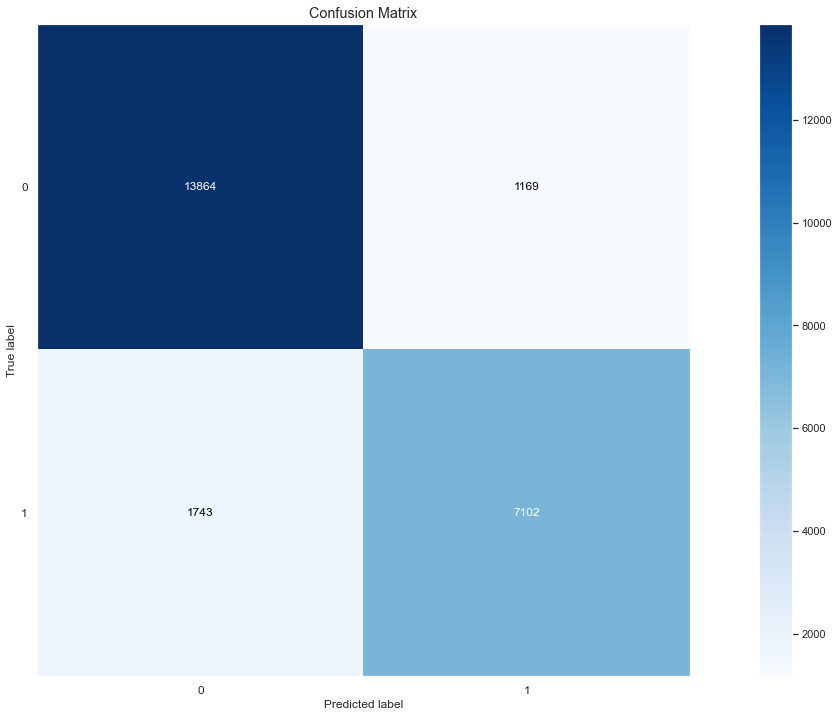

In [90]:
lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42)

lgbm_model.fit(X_train, y_train.values.ravel())

yhat_lgbm = lgbm_model.predict_proba(X_test)

df_lgbm = pd.DataFrame(yhat_lgbm)
df_lgbm[2] = df_lgbm[1].apply(lambda x:1 if x>=0.5 else 0)
df_lgbm[3] = y_test['is_canceled'].reset_index(drop=True)

mtr.plot_cumulative_gain(y_test, yhat_lgbm, figsize=(10,6))

mtr.plot_lift_curve(y_test, yhat_lgbm, figsize=(10,6))

metrics = metrics_score('LGBM', df_lgbm)
models = models.append(metrics, ignore_index=True)

print(metrics)

mtr.plot_confusion_matrix(df_lgbm[3], df_lgbm[2])

## 7.6 Model Performance

In [91]:
models.style.highlight_max(color = 'cornflowerblue', axis = 0)

,Model,accuracy,precision,recall,roc_auc_score,f1_score
0,KNN,0.808694,0.762941,0.701526,0.874117,0.730946
1,Random Forest,0.896976,0.883299,0.831769,0.962098,0.856760
2,Extra Tree,0.891741,0.871999,0.829508,0.957241,0.850223
3,XG Boost,0.883365,0.860543,0.817637,0.954911,0.838541
4,LGBM,0.878047,0.858663,0.802940,0.951921,0.829867


## 7.7 Performance with Cross Validation

In [92]:
model_name = [(knn_model, 'KNN'), (rf_model, 'Random Forest'), (et_model, 'Extra Trees'), (xgb_model, 'XG Boost'), (lgbm_model, 'LGBM')]
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

mcv = pd.DataFrame()
models_cv = cross_validation(model_name, kfold = 3, mcv = [])

models_cv.style.highlight_max(color = 'cornflowerblue', axis = 0)

,Model,accuracy,precision,recall,roc_auc_score,f1_score
0,KNN,0.797785,0.748502,0.683880,0.860522,0.714722
1,Random Forest,0.892035,0.882543,0.817349,0.958485,0.848670
2,Extra Trees,0.887271,0.873507,0.813477,0.954582,0.842414
3,XG Boost,0.882235,0.856171,0.819808,0.953895,0.837589
4,LGBM,0.877178,0.854812,0.805195,0.950617,0.829252


# 8.0 Hyperparameter Fine Tuning

In [93]:
param_rf = {'n_estimators': (100, 200, 500),
            'max_features': ( 6, 8, 10, 'auto')}

par = sorted(param_rf)
combinations = it.product(*(param_rf[Name] for Name in par))
list1 = list(combinations)


for i in range (len(list1)):
    params= {par[0]: list1[i][0], par[1]: list1[i][1]}
    
    model_rf = RandomForestClassifier(n_estimators = params['n_estimators'],
                                         max_features = params['max_features'],
                                         random_state = 42,
                                         n_jobs = -1)

    model_rf.fit(X_train, y_train.values.ravel())

    yhat_rf = model_rf.predict_proba(X_test)
    
    df_rf = pd.DataFrame(yhat_rf)
    df_rf[2] = df_rf[1].apply(lambda x: 1 if x>=0.5 else 0)
    df_rf[3] = y_test['is_canceled'].reset_index(drop=True)
        
    metrics = metrics_score('Random Forest', df_rf)
    
    if i ==0:
        model_hft = metrics
    else:
        model_hft = model_hft.append(metrics, ignore_index=True)
        
result = pd.DataFrame({'Model Name': 'Random Forest',
                    'Accuracy': np.round(np.mean(model_hft['accuracy']), 2).astype(str) + ' +/- ' + np.round(np.std(model_hft['accuracy']), 2).astype(str),
                    'Precision': np.round(np.mean(model_hft['precision']), 2).astype(str) + ' +/- ' + np.round(np.std(model_hft['precision']), 2).astype(str),
                    'Recall': np.round(np.mean(model_hft['recall']), 2).astype(str) + ' +/- ' + np.round(np.std(model_hft['recall']), 2).astype(str),
                    'Roc_Auc_Score' : np.round(np.mean(model_hft['roc_auc_score']), 2).astype(str) + ' +/- ' + np.round(np.std(model_hft['roc_auc_score']), 2).astype(str),
                    'F1_Score': np.round(np.mean(model_hft['f1_score']), 2).astype(str) + ' +/- ' + np.round(np.std(model_hft['f1_score']), 2).astype(str)}, index=[0])

In [94]:
model_hft

,Model,accuracy,precision,recall,roc_auc_score,f1_score
0,Random Forest,0.897604,0.881588,0.835839,0.962327,0.858105
1,Random Forest,0.898065,0.883204,0.835274,0.962938,0.858571
2,Random Forest,0.898526,0.883449,0.836405,0.963017,0.859283
3,Random Forest,0.897814,0.879398,0.839231,0.962308,0.858845
4,Random Forest,0.898735,0.881424,0.839570,0.962945,0.859988
5,Random Forest,0.898526,0.880450,0.840136,0.963163,0.859821
6,Random Forest,0.898191,0.878809,0.841153,0.962138,0.859569
7,Random Forest,0.898316,0.879390,0.840814,0.962869,0.859669
8,Random Forest,0.898442,0.879612,0.840927,0.963156,0.859835
9,Random Forest,0.896976,0.883299,0.831769,0.962098,0.856760


In [95]:
result

,Model Name,Accuracy,Precision,Recall,Roc_Auc_Score,F1_Score
0,Random Forest,0.9 +/- 0.0,0.88 +/- 0.0,0.84 +/- 0.0,0.96 +/- 0.0,0.86 +/- 0.0


## 8.1 Final Model

In [158]:
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

rf_model.fit(X_train, y_train.values.ravel())

yhat_rf = rf_model.predict_proba(X_test)

df_rf = pd.DataFrame(yhat_rf)
df_rf[2] = df_rf[1].apply(lambda x: 1 if x>=0.5 else 0)
df_rf[3] = y_test['is_canceled'].reset_index(drop=True)

# 9.0 Business Perfomance

In [261]:
df = pd.read_csv('reservations.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [338]:
var1 = (len(df)*100) - (len(df[(df['is_canceled']==1) & (df['campaign']==1)])*600)

In [339]:
aux = df[df['probability']>0.5]

aux = aux.sort_values(by='probability')

aux = aux.head(1000)

var2 = (len(aux[(aux['is_canceled']==1) & (aux['campaign']==1)])*600) - (len(aux)*100)

var3 = len(aux[(aux['is_canceled']==1) & (aux['campaign']==1)])/10

In [340]:
aux = df[df['probability']>0.5]

aux = aux.sort_values(by='probability')

aux = aux.head(2000)

var4 = (len(aux[(aux['is_canceled']==1) & (aux['campaign']==1)])*600) - (len(aux)*100)

var5 = len(aux[(aux['is_canceled']==1) & (aux['campaign']==1)])/20

In [341]:
aux = df[df['probability']>0.5]

var6 = (len(aux[(aux['is_canceled']==1) & (aux['campaign']==1)])*600) - (len(aux)*100)

var7 = (len(aux[(aux['is_canceled']==1) & (aux['campaign']==1)])*100)/(len(aux))

In [342]:
df['campaign'].value_counts()

0.0    9070
1.0     930
Name: campaign, dtype: int64

## 9.1 Main Insights

There is a higher percentage of canceled reservations at City Hotels

Reservations made by families with babies are less likely to be canceled

Group is the only market segmentation in which the number of canceled  reservations is more than half

Reservations made by customers with previous cancellations are canceled 90% of the time

## 9.2 Reaching all Reservations

In [343]:
print('If the campaign were intended for all reservations, there would be a loss of ${}.'.format(var1))

If the campaign were intended for all reservations, there would be a loss of $591400.


## 9.3 Model Implementation

### 9.3.1 Reaching 10% of Reservations

In [345]:
print('If the campaign were intended for only 10% of the reservations most likely to have a positive return, there would be a profit of ${}'.format(var2))
print('{}% of the campaign budget would go to the right customers'.format(var3))

If the campaign were intended for only 10% of the reservations most likely to have a positive return, there would be a profit of $183800
47.3% of the campaign budget would go to the right customers


### 9.3.2 Reaching 20% of Reservations

In [347]:
print('If the campaign were intended for only 20% of the reservations most likely to have a positive return, there would be a profit of ${}'.format(var4))
print('{}% of the campaign budget would go to the right customers'.format(var5))

If the campaign were intended for only 20% of the reservations most likely to have a positive return, there would be a profit of $208600
34.05% of the campaign budget would go to the right customers


### 9.3.3 Reaching all predicted canceled reservations

In [351]:
print('If the campaign were intended for all the reservations predicted as canceled, there would be a profit of ${}'.format(var6))
print('{:.2f}% of the campaign budget would go to the right customers'.format(var7))

If the campaign were intended for all the reservations predicted as canceled, there would be a profit of $57500
19.40% of the campaign budget would go to the right customers
